In [3]:
import pandas as pd
from evaluate import p_mismatch, p_error_2_phred, phred_2_p_error
import scipy.stats as st
from matplotlib import pyplot as plt

In [2]:
# def plot_confidence_interval(x, mean, lower, upper, color='#2187bb', 
#                              horizontal_line_width=0.6):
#     left = x - horizontal_line_width / 2
#     right = x + horizontal_line_width / 2
#     plt.plot([x, x], [upper, lower], color=color, lw=0.6)
#     plt.plot([left, right], [upper, upper], color=color, lw=0.6)
#     plt.plot([left, right], [lower, lower], color=color, lw=0.6)
#     plt.plot(x, mean, '.', color=color)


# def plot_observed_vs_predicted_phred(df_program, program, alpha, outdir=None):

#     fig, ax = plt.subplots(figsize=(12, 8))

#     # Plot the guideline
#     ax.plot(df_program.index, df_program.index, "--r", lw=0.8)
#     # Plot each conf interval
#     for x in df_program.index:
#         mean = df_program["observed_phred_mean"][x]
#         lower = df_program["observed_phred_lower"][x]
#         upper = df_program["observed_phred_upper"][x]
#         plot_confidence_interval(x, mean, lower, upper, color="k")

#     ax.text(35, 5, f"alpha = {alpha}",)

#     # Show all values on x axes
#     plt.xticks(df_program.index, size="x-small")
#     # Set x axes limits
#     ax.set_xlim(left=df_program.index[0]-1, right=df_program.index[-1]+1) 
#     # Add grid
#     ax.set_axisbelow(True)
#     plt.grid(alpha=0.5)
#     # Add labels
#     ax.set_title(f"{program}")
#     ax.set_xlabel(f"Merged Phred")
#     ax.set_ylabel(f"Observed Phred")


#     # # Save plot
#     # fig.tight_layout()
#     # plt.savefig(f"{program}.png", 
#     #             dpi='figure', 
#     #             format="png")


#     plt.show()
    
    
# def main(infile, outdir=None):
    
#     alpha = 0.01
    
#     df = pd.read_csv(infile)
#     for program in list(df["program"].unique()):
        
#         # Only take data for one program 
#         df_program = df[df["program"] == program]
#         # add the counts of the datasets with the different qual_shift
#         df_program = df_program[["predicted_phred", 
#                                 "n_matches", 
#                                 "n_mismatches", 
#                                 "n_total"]
#                                 ].groupby("predicted_phred").sum()
        
#         # Calculate the new observed phred with confidence intervall
#         df_program["p_mismatch"] = df_program.apply(
#             lambda x: p_mismatch(x["n_total"], x["n_mismatches"]), 
#             axis=1
#             )
#         df_program["error_margin"] = df_program.apply(
#             lambda x: margin_of_error(x["n_total"], x["p_mismatch"], 
#                                       alpha=alpha), 
#             axis=1
#             )
#         df_program["observed_phred_mean"] = df_program.apply(
#             lambda x: p_error_2_phred(x["p_mismatch"]), 
#             axis=1
#             )
#         df_program["observed_phred_lower"] = df_program.apply(
#             lambda x: p_error_2_phred(x["p_mismatch"]+x["error_margin"]),
#             axis=1
#             )
#         df_program["observed_phred_upper"] = df_program.apply(
#             lambda x: p_error_2_phred(x["p_mismatch"]-x["error_margin"]),
#             axis=1
#             )   
#         plot_observed_vs_predicted_phred(df_program, program, alpha)

In [1]:
def combine_quality_scores(df, alpha):
    df2 = df[["predicted_phred", "n_matches", "n_mismatches", "n_total"]] \
           .groupby("predicted_phred") \
           .sum()
    df2["predicted_phred"] = df2.index
    df2["predicted_p_mismatch"] = df2.apply(
        lambda x: phred_2_p_error(x["predicted_phred"]), axis=1)

    df2["p_mismatch"] = df2.apply(
        lambda x: p_mismatch(x["n_total"], x["n_mismatches"]), 
        axis=1
        )
    df2["p_mismatch_lower"] = df2.apply(
        lambda x: binomial_ci(x["n_total"], x["n_mismatches"], alpha)[0], 
        axis=1)
    df2["p_mismatch_upper"] = df2.apply(
        lambda x: binomial_ci(x["n_total"], x["n_mismatches"], alpha)[1], 
        axis=1
        )
    df2["observed_phred"] = df2.apply(
        lambda x: p_error_2_phred(x["p_mismatch"]), 
        axis=1
        )
    df2["observed_phred_lower"] = df2.apply(
        lambda x: p_error_2_phred(x["p_mismatch_upper"]),
        axis=1
        )
    df2["observed_phred_upper"] = df2.apply(
        lambda x: p_error_2_phred(x["p_mismatch_lower"]),
        axis=1
        )   
    return df2


def weighted_r_squared(df):
    """
    weighted mean: https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/weighted-mean/
    weighted r squared: https://stats.stackexchange.com/questions/83826/is-a-weighted-r2-in-robust-linear-model-meaningful-for-goodness-of-fit-analys/375752#375752 
    """
    y_hat = df["observed_phred"]
    # Weights are the confidence interval
    conf_intervals = df["observed_phred_upper"] - df["observed_phred_lower"]
    weights = [1/w for w in conf_intervals]
    # difference between merged and observed phred
    residuals = df["observed_phred"] - df["predicted_phred"]

    # weighted residual sum of squared (SSe)
    sse = sum([w * e**2 for w, e in zip(weights, residuals)])
    # weighted total sum of squared (SSt)
    weighted_mean = sum([w * f for w, f in zip(weights, y_hat)]) / sum(weights)
    sst = sum([w * (f-weighted_mean)**2 for w, f in zip(weights, y_hat)])
    # weighted r squared
    r2 = 1 - (sse/sst)

    return r2


def weighted_r_squared(df):
    """
    weighted mean: https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/weighted-mean/
    weighted r squared: https://stats.stackexchange.com/questions/83826/is-a-weighted-r2-in-robust-linear-model-meaningful-for-goodness-of-fit-analys/375752#375752 
    """
    y = df["observed_phred"]
    # Weights are the confidence interval
    conf_intervals = df["observed_phred_upper"] - df["observed_phred_lower"]
    weights = [1/w for w in conf_intervals]
    # difference between merged and observed phred
    residuals = y - df["predicted_phred"]
    
    # weighted residual sum of squared (SSe)
    sse = sum([w * e**2 for w, e in zip(weights, residuals)])
    # weighted total sum of squared (SSt)
    weighted_mean = sum([w * f for w, f in zip(weights, y)]) / sum(weights)
    sst = sum([w * (f-weighted_mean)**2 for w, f in zip(weights, y)])
    # weighted r squared
    r2 = 1 - (sse/sst)

    return r2


def binomial_ci(n, k, alpha):
    """ 
    Exact Confidence Interval
    https://sigmazone.com/binomial-confidence-intervals/ 
    """
    if k == 0:
        p_lower = 0
    else: 
        p_lower = 1 - st.beta.ppf(1-(alpha/2), n-k+1 , k)
    if k == n:
        p_upper = 1
    else:
        p_upper = 1 - st.beta.ppf(alpha/2, n-k , k+1)
    return p_lower, p_upper


def plot_confidence_interval(x, y, lower, upper, color='#2187bb', 
                             horizontal_line_width=0.6):
    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    plt.plot([x, x], [upper, lower], color=color, lw=0.6)
    plt.plot([left, right], [upper, upper], color=color, lw=0.6)
    plt.plot([left, right], [lower, lower], color=color, lw=0.6)
    plt.plot(x, y, '.', color=color)
    
    
def plot_phred_calibration(df_qs, program, r2, alpha, outdir, qs=None):

    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the expected line
    ax.plot(df_qs["predicted_phred"], df_qs["predicted_phred"], "--r", lw=0.8)
    # Plot each conf interval
    idx = df_qs.index
    for i in idx:
        x = df_qs["predicted_phred"][i]
        y = df_qs["observed_phred"][i]
        lower = df_qs["observed_phred_lower"][i]
        upper = df_qs["observed_phred_upper"][i]
        plot_confidence_interval(x, y, lower, upper, color="k")
    # Add grid
    ax.set_axisbelow(True)
    plt.grid(alpha=0.5)
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # Plot the phred distribution
    ax2.bar(df_qs["predicted_phred"], df_qs["n_total"], alpha=0.2)

    # Add alpha information (used to calculate conf interval)
    ax.text(.01, .95, f"weighted R2 = {round(r2, 5)}", fontsize=14, 
            style='normal', ha='left', va='top', transform=ax.transAxes)
    ax.text(.01, .9, f"α={alpha}", fontsize=14, color='grey', 
            style='italic', ha='left', va='top', transform=ax.transAxes)
    
    # Show all values on x axes
    plt.xticks(range(df_qs["predicted_phred"][idx[0]], 
                     df_qs["predicted_phred"][idx[-1]] + 1), 
               size="xx-small")
    # Set x axes limits
    ax.set_xlim(left=df_qs["predicted_phred"][idx[0]]-0.5, 
                right=df_qs["predicted_phred"][idx[-1]]+0.5) 
    # Add labels
    if qs is None:
        plt.title(f"{program}", loc='left', fontsize=16)
    else:
        plt.title(f"{program}, quality shift: {qs}", loc='left', fontsize=16)
    ax.set_xlabel(f"Merged Phred")
    ax.set_ylabel(f"Observed error rate (phred scale)")
    ax2.set_ylabel("Total count")

    # Save plot
    fig.tight_layout()
    if outdir is not None:
        if qs is None:
            plt.savefig(f"{outdir}/{program}_combined.png", 
                dpi='figure', 
                format="png")
        else:
            plt.savefig(f"{outdir}/{program}_{qs}.png", 
                        dpi='figure', 
                        format="png")
    else:
        plt.show()
    plt.close(fig)


def main(infile, outdir):
    
    alpha = 0.01
    
    df = pd.read_csv(infile)
    
    # Only take data for one program and quality shift 
    for program in list(df["program"].unique()):
        df_program = df[df["program"] == program]
        # combine the counts from the different quality shifts
        df_combined = combine_quality_scores(df_program, alpha)
        r2 = weighted_r_squared(df_combined)
        plot_phred_calibration(df_combined, program, r2, alpha, outdir, 
                               qs=None)
        
        for qs in list(df_program["qual_shift"].unique()):
            df_qs = df_program[df_program["qual_shift"] == qs]
            r2 = weighted_r_squared(df_qs)
            plot_phred_calibration(df_qs, program, r2, alpha, outdir, qs=qs)


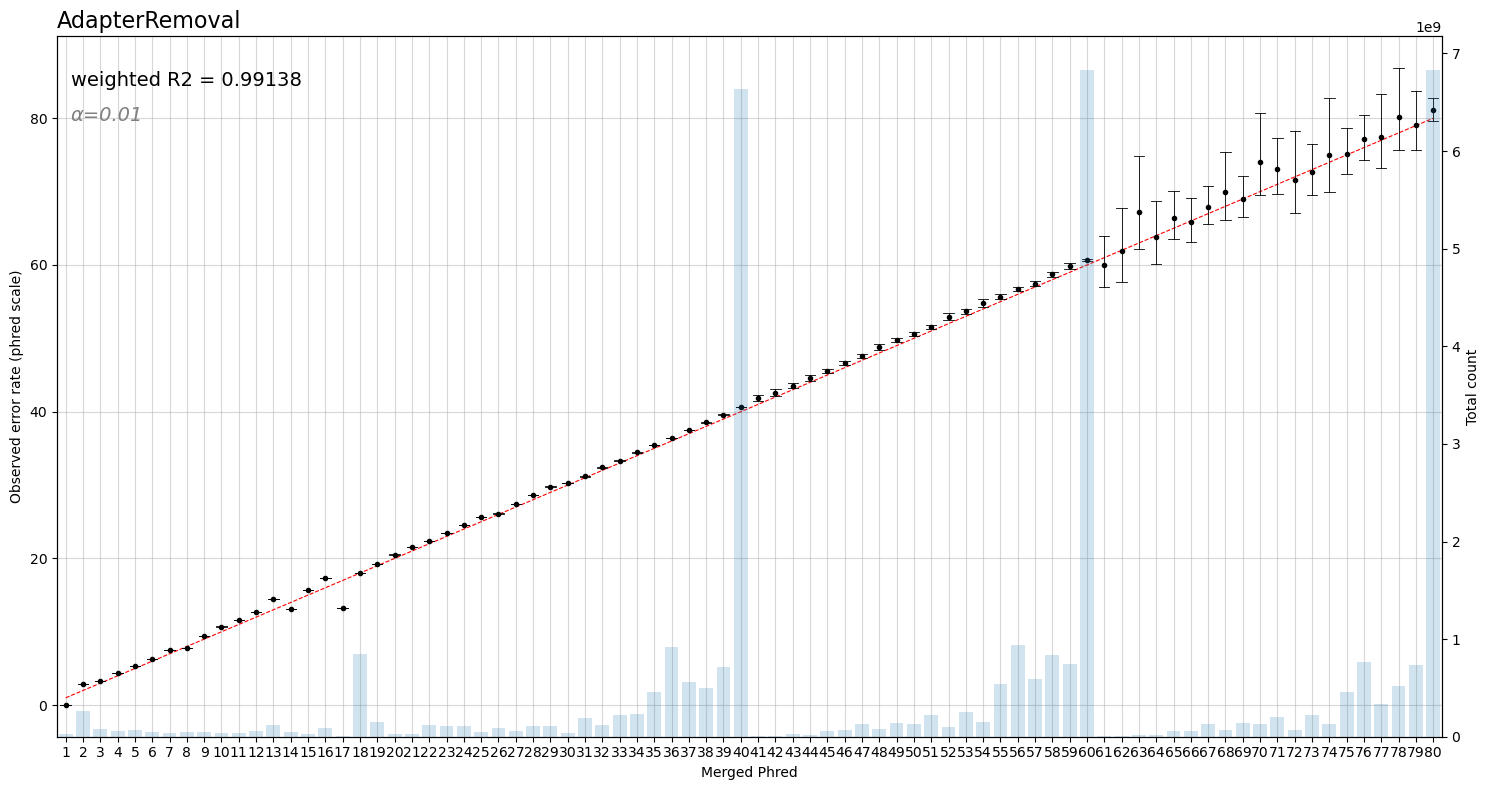

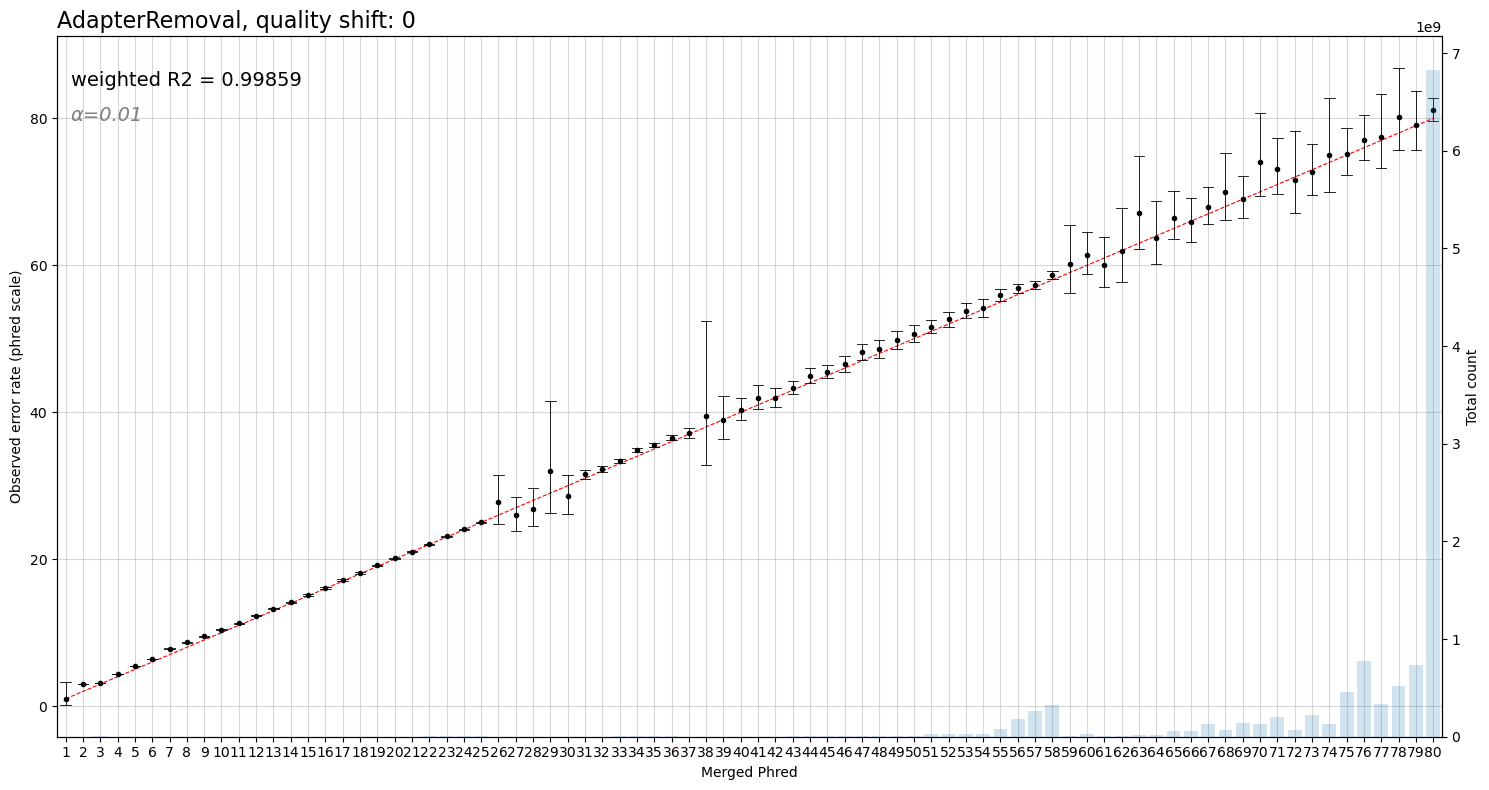

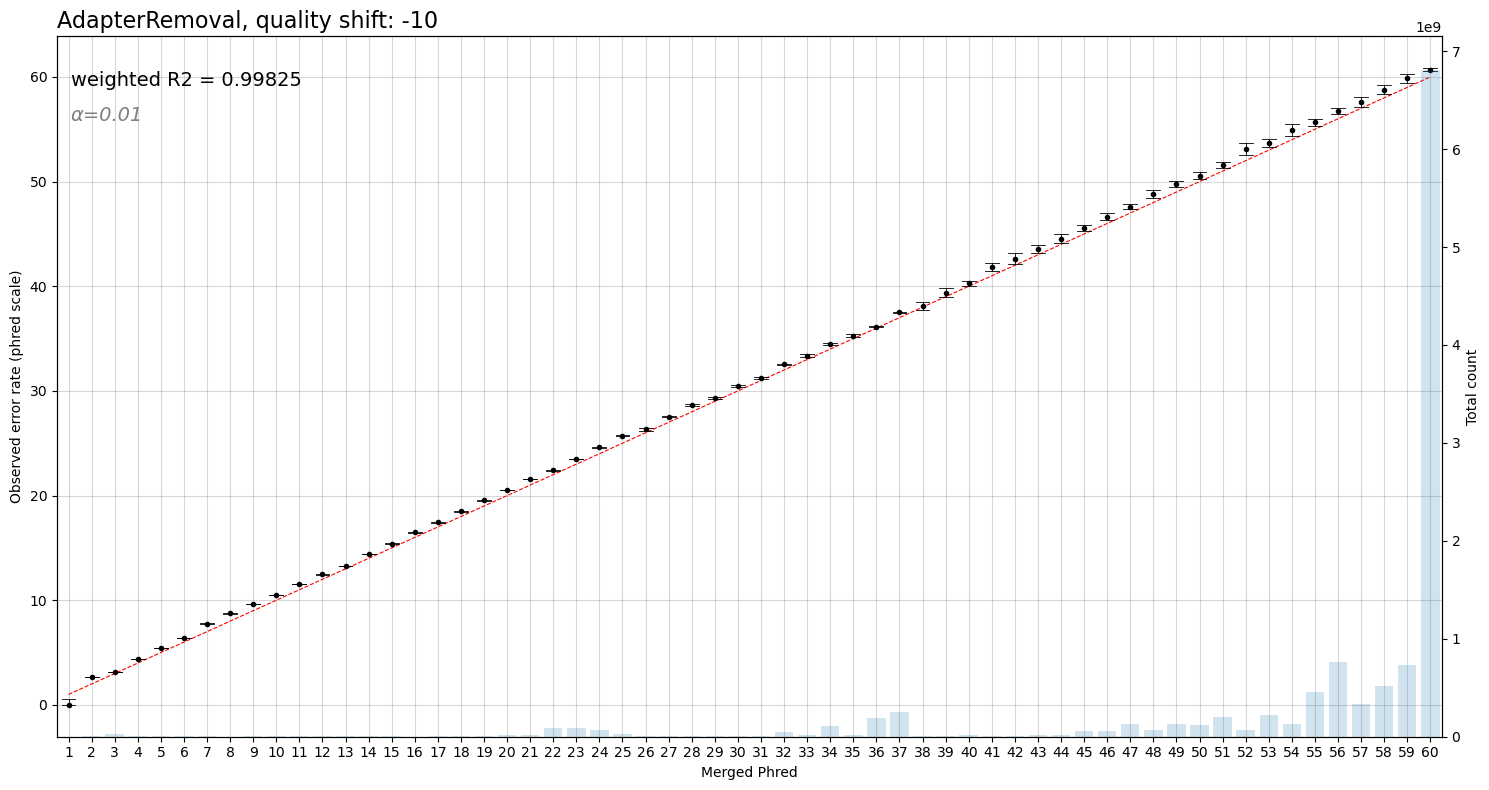

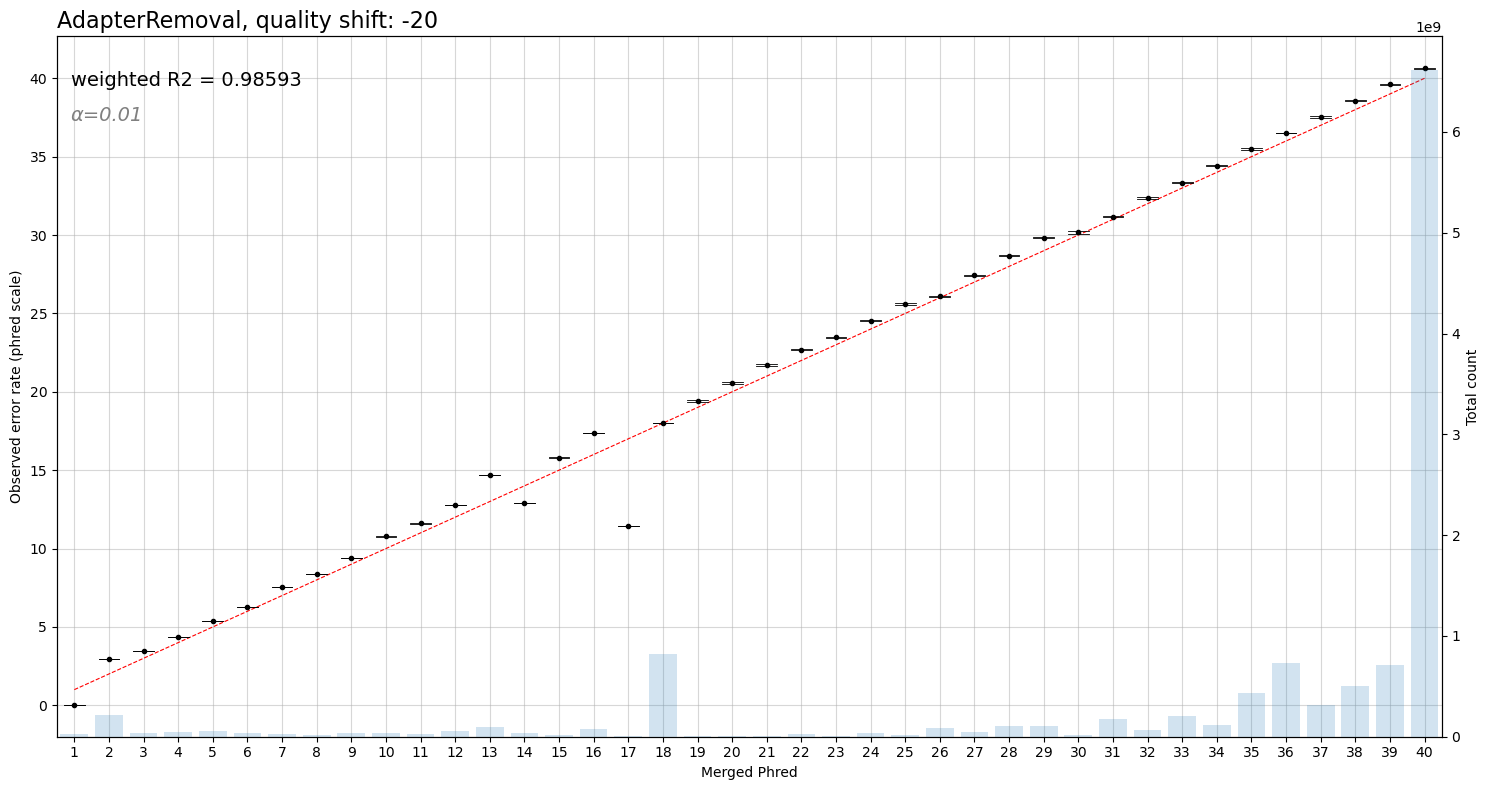

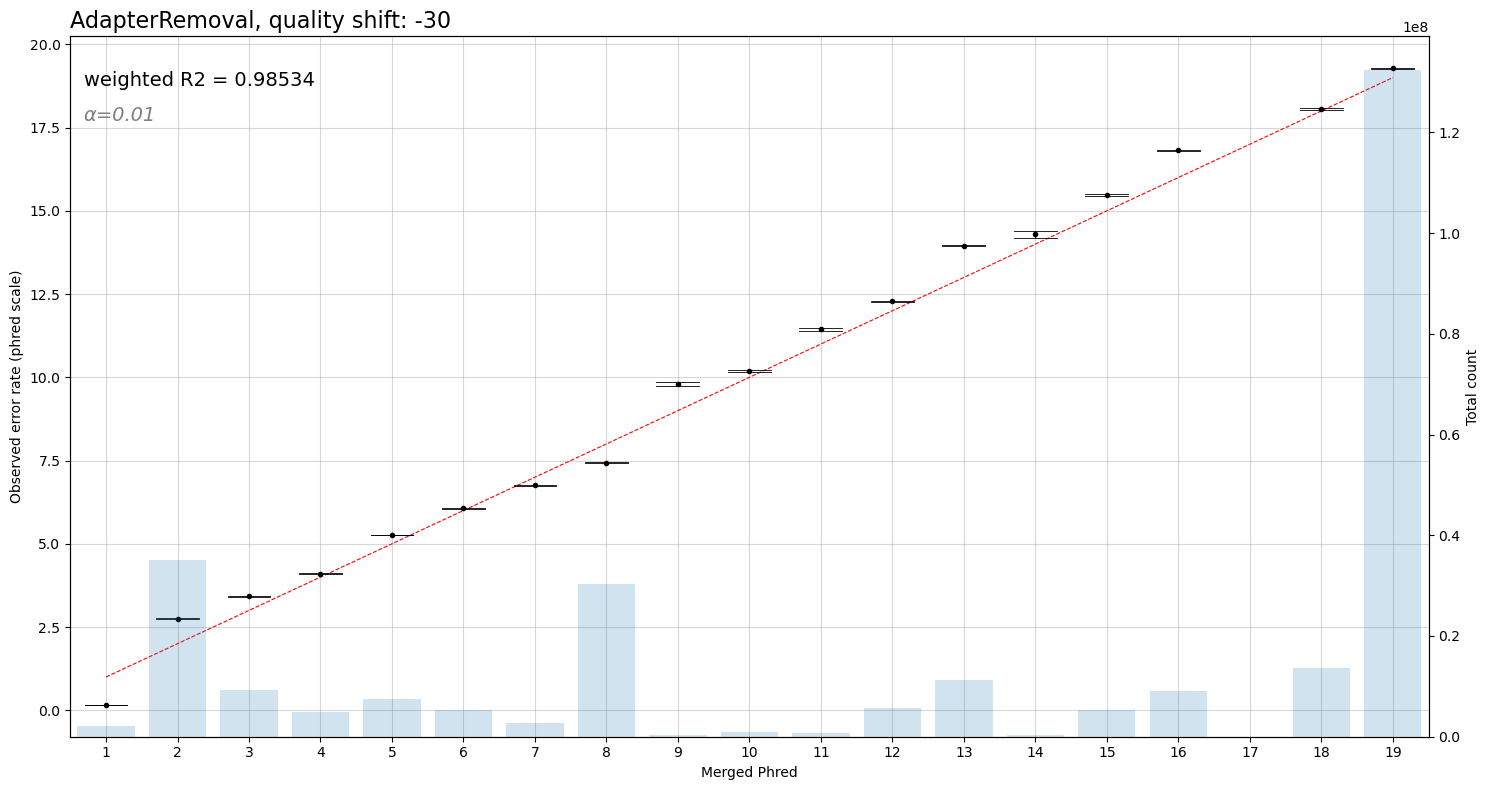

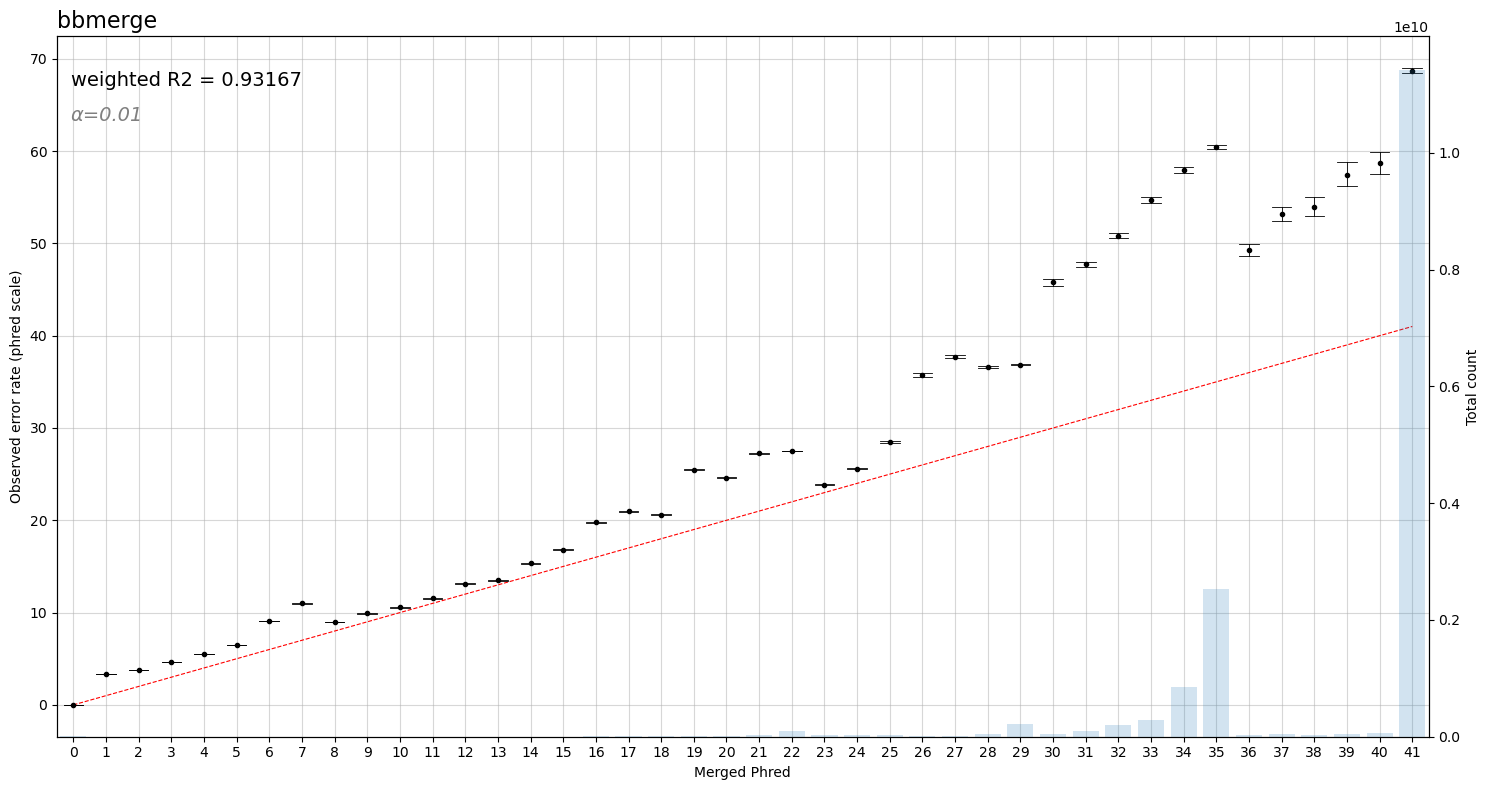

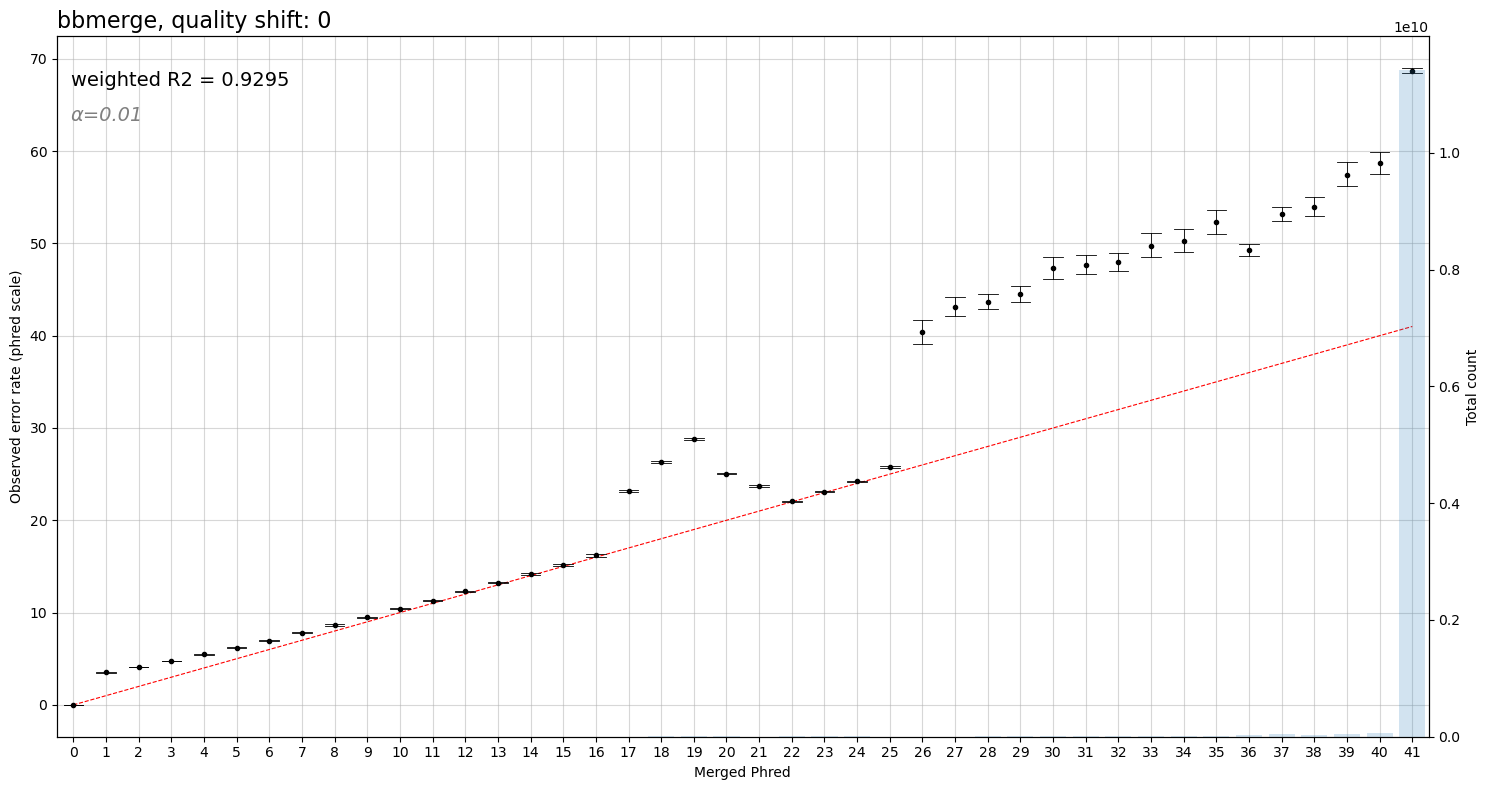

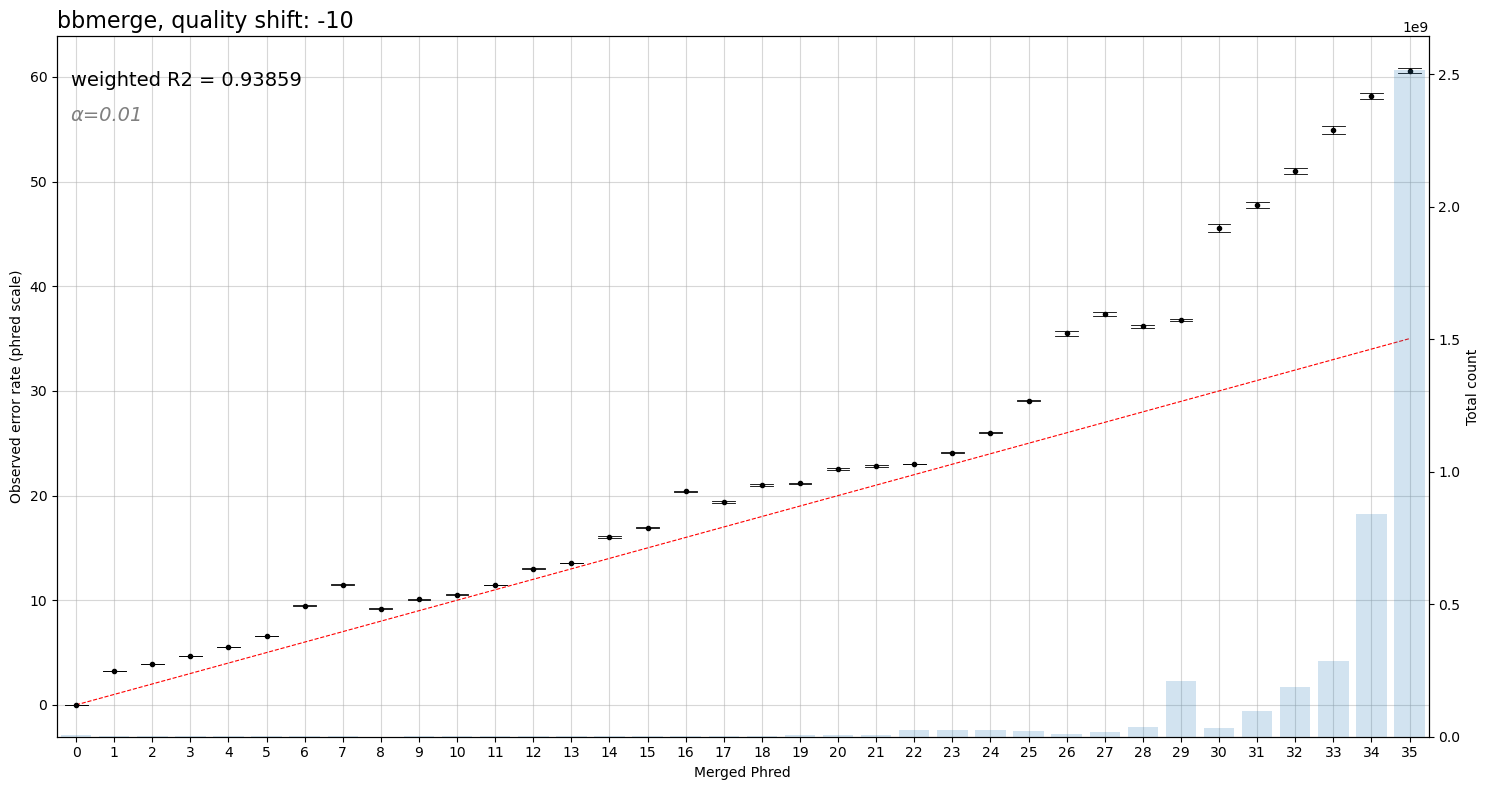

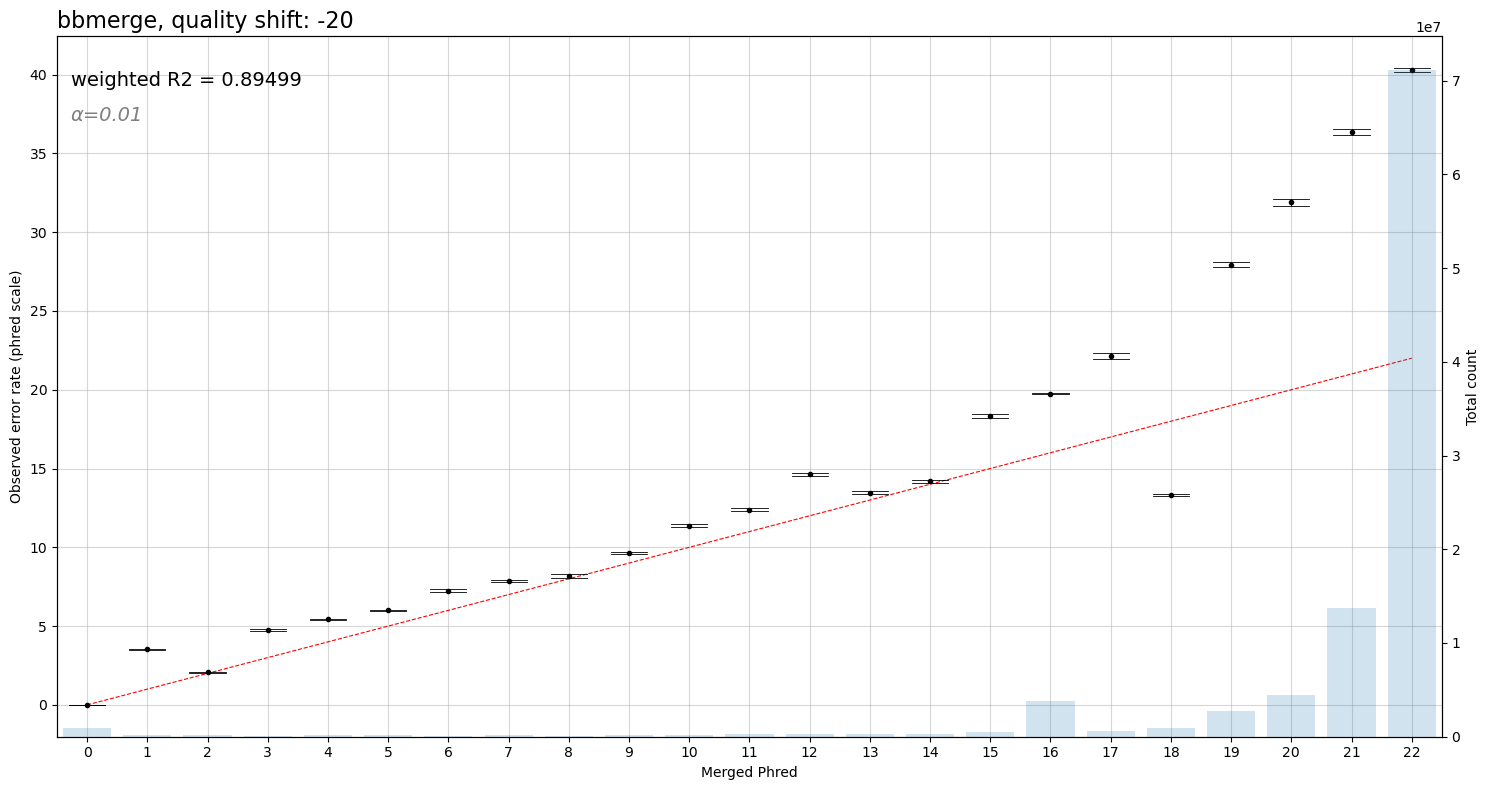

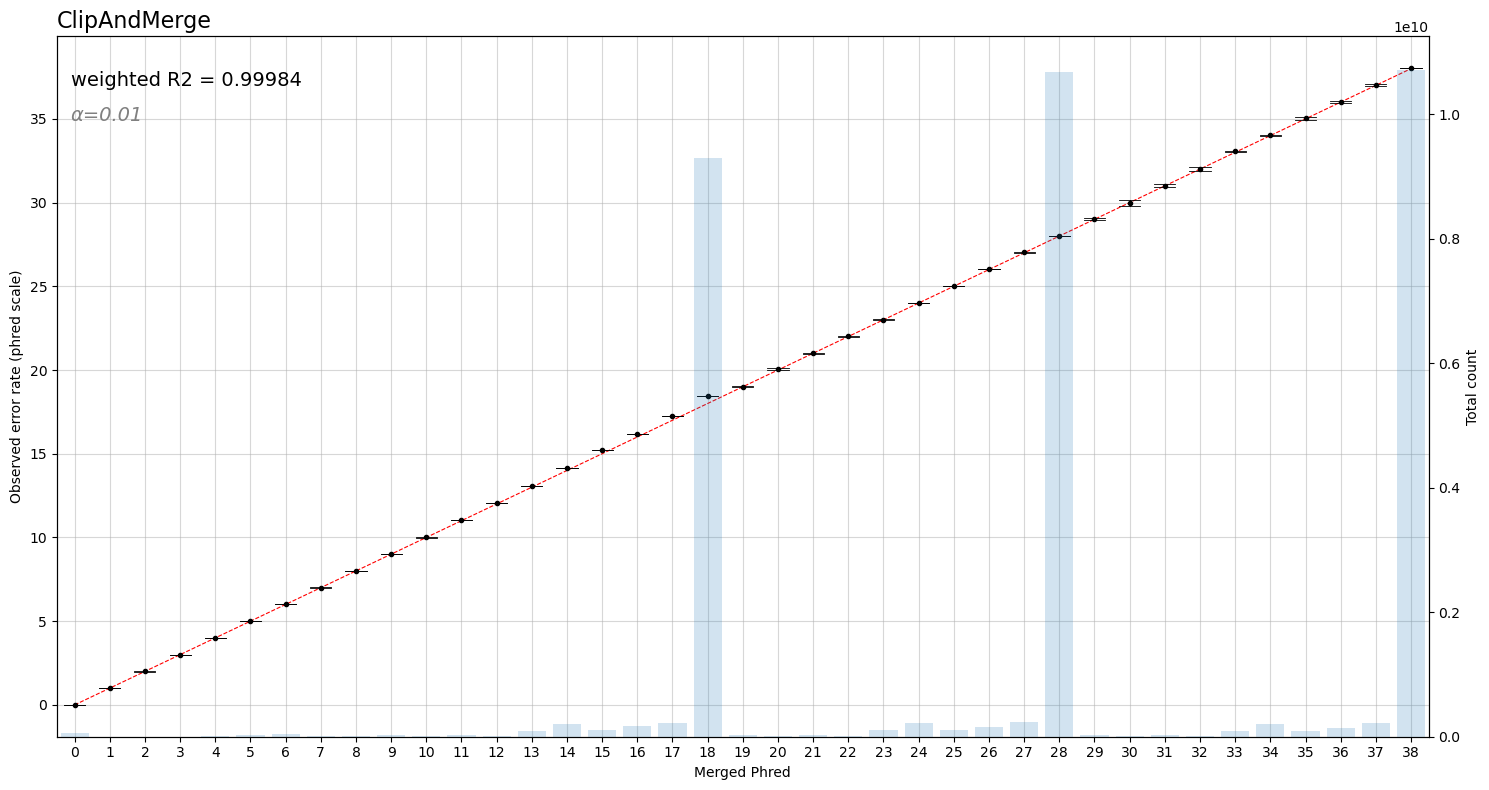

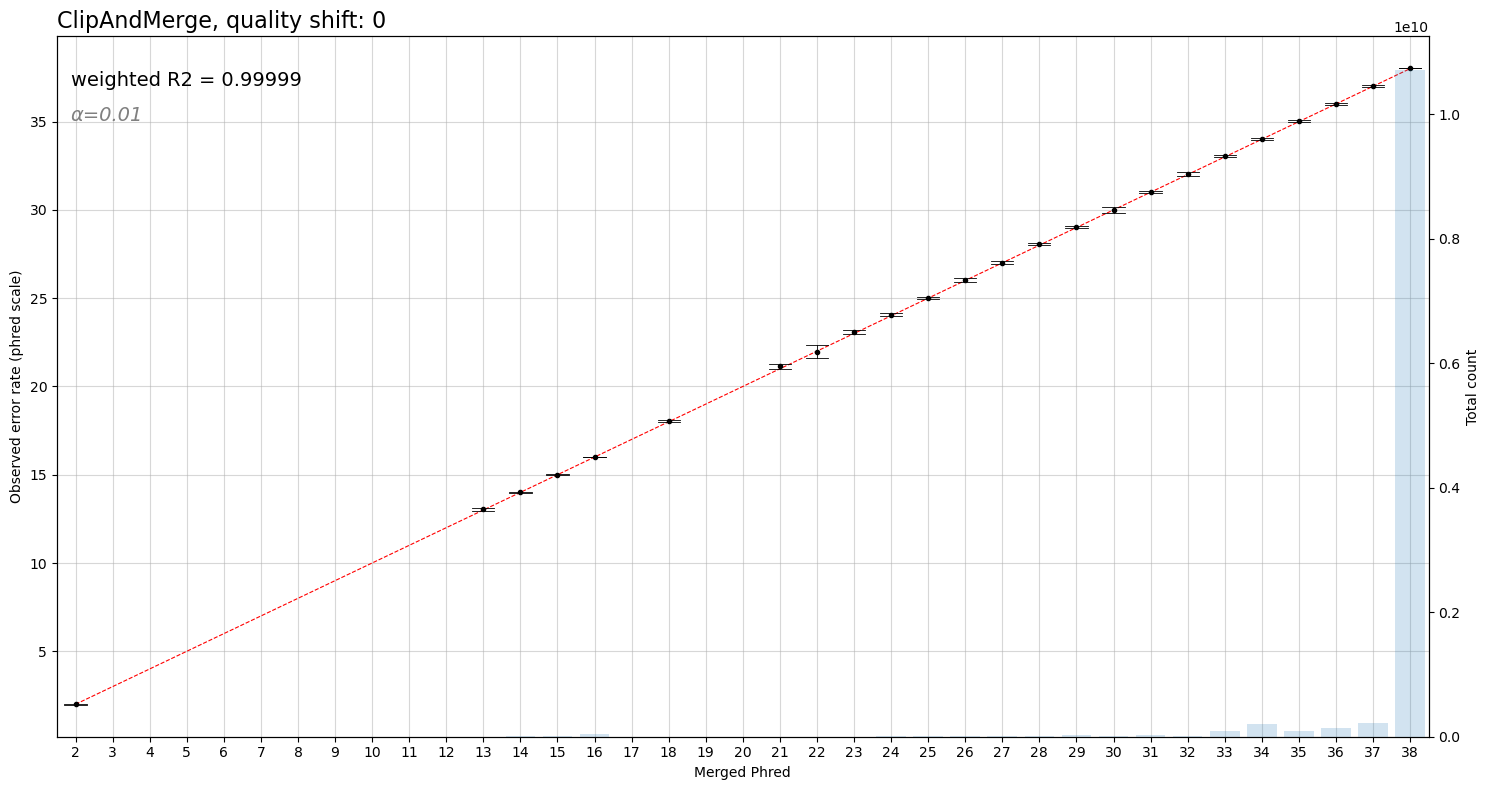

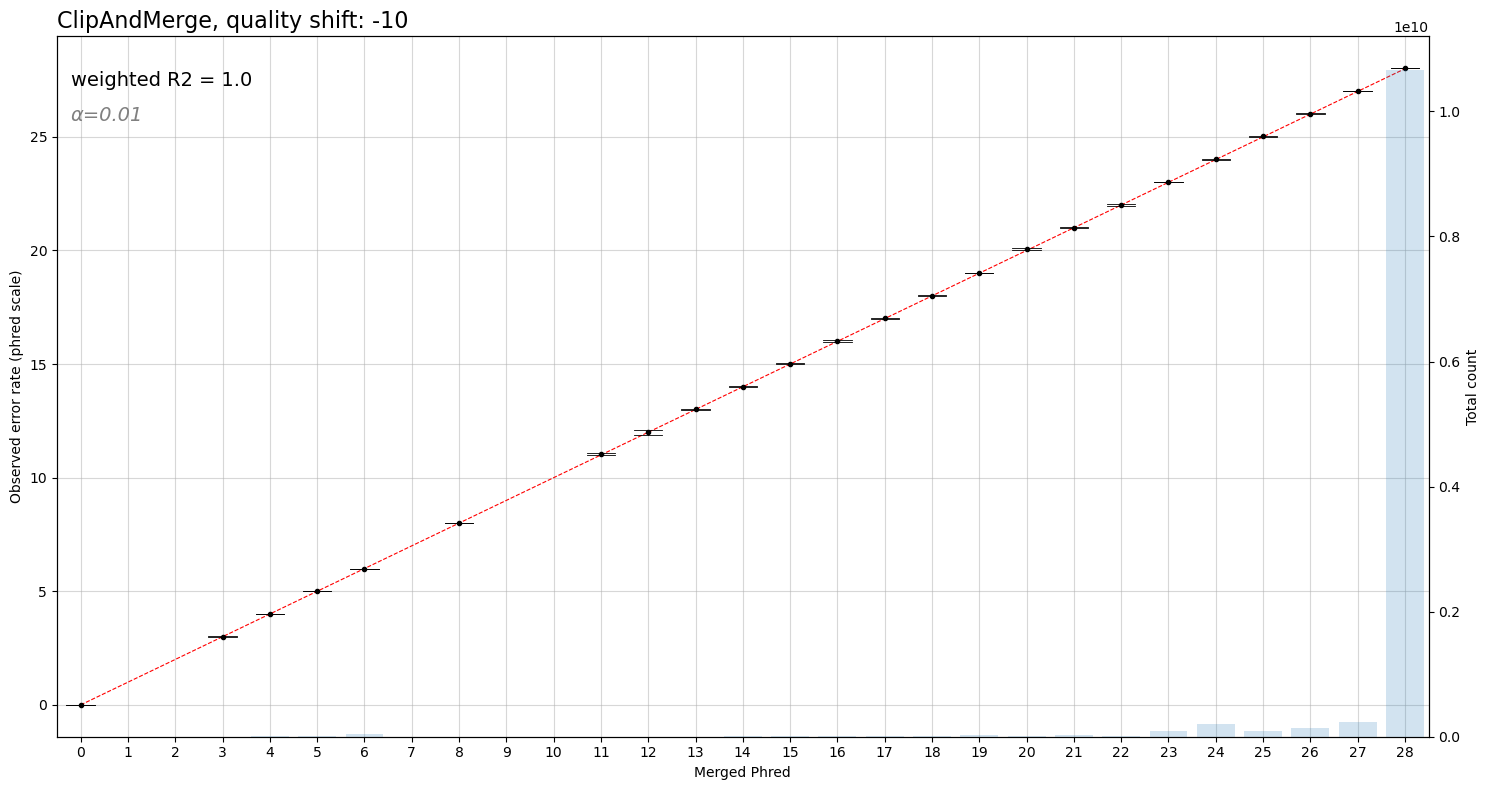

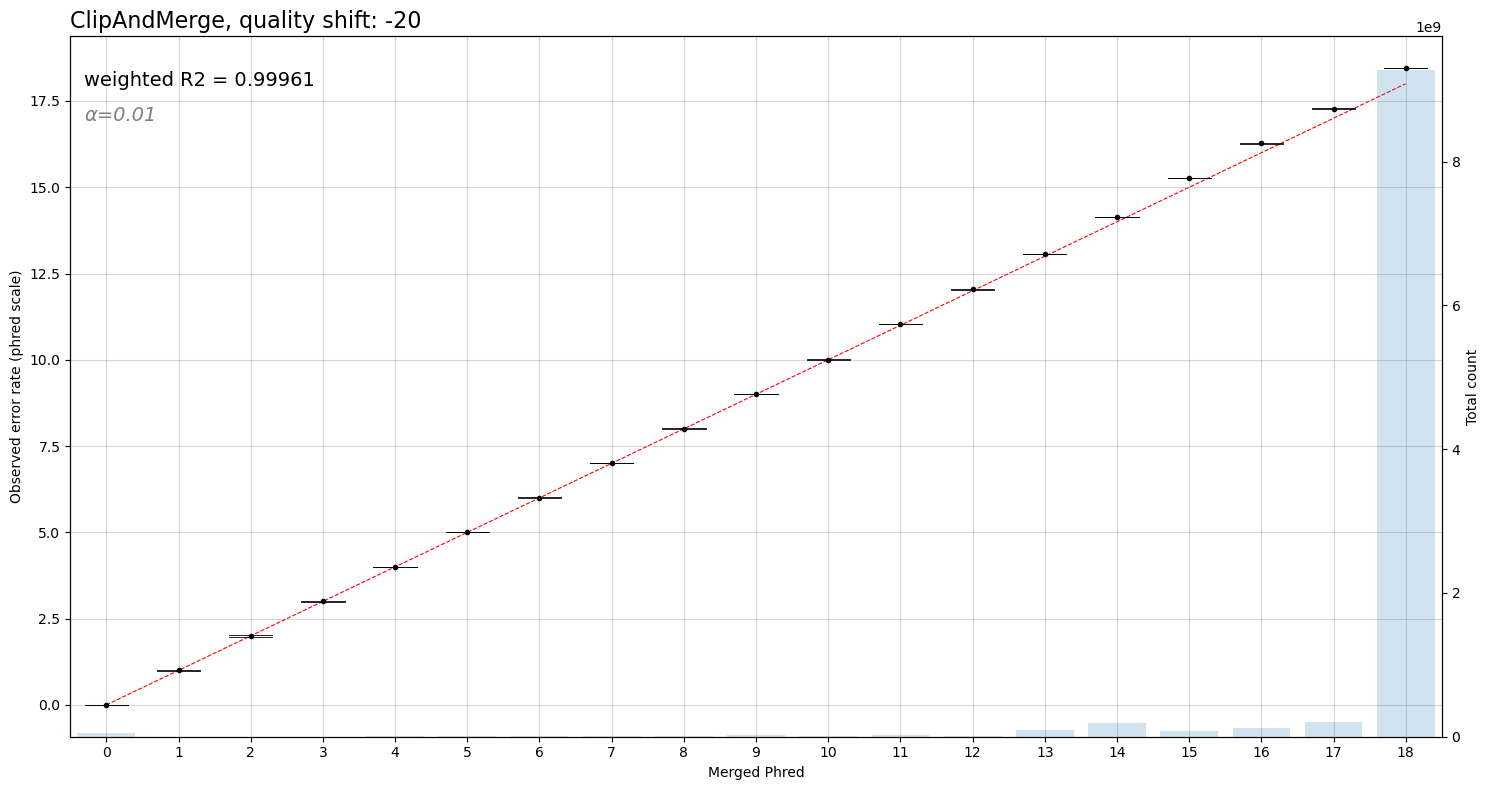

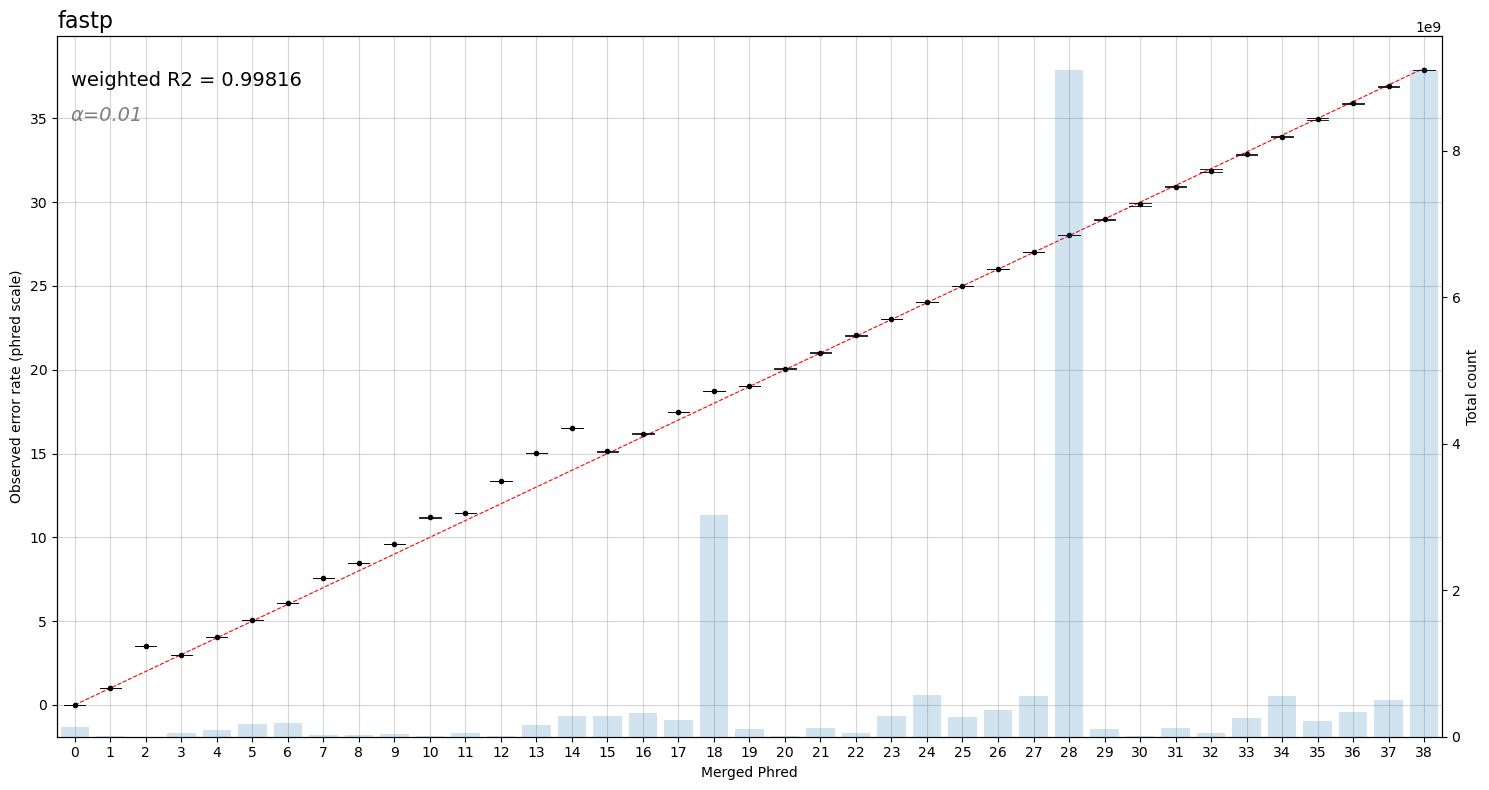

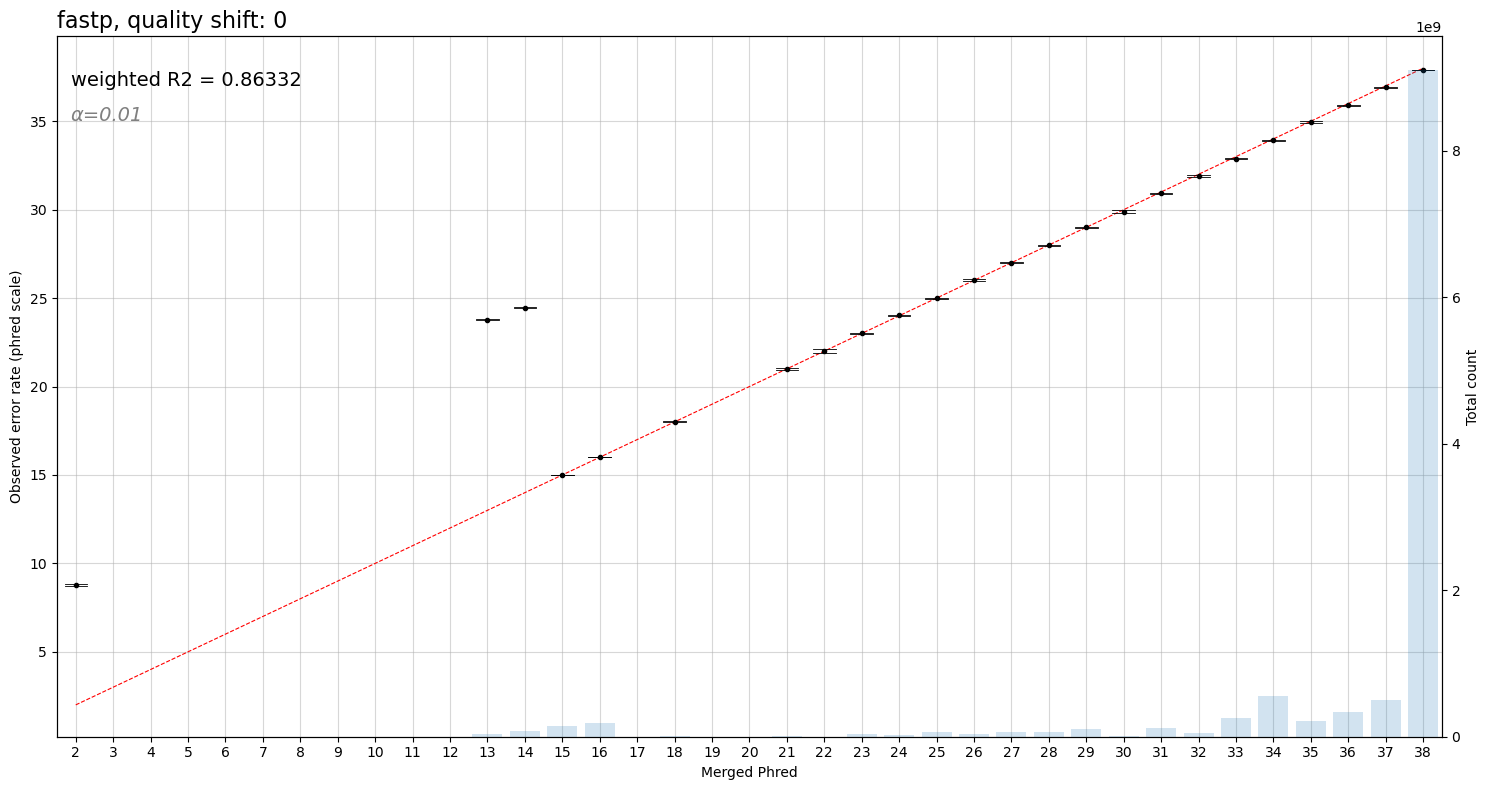

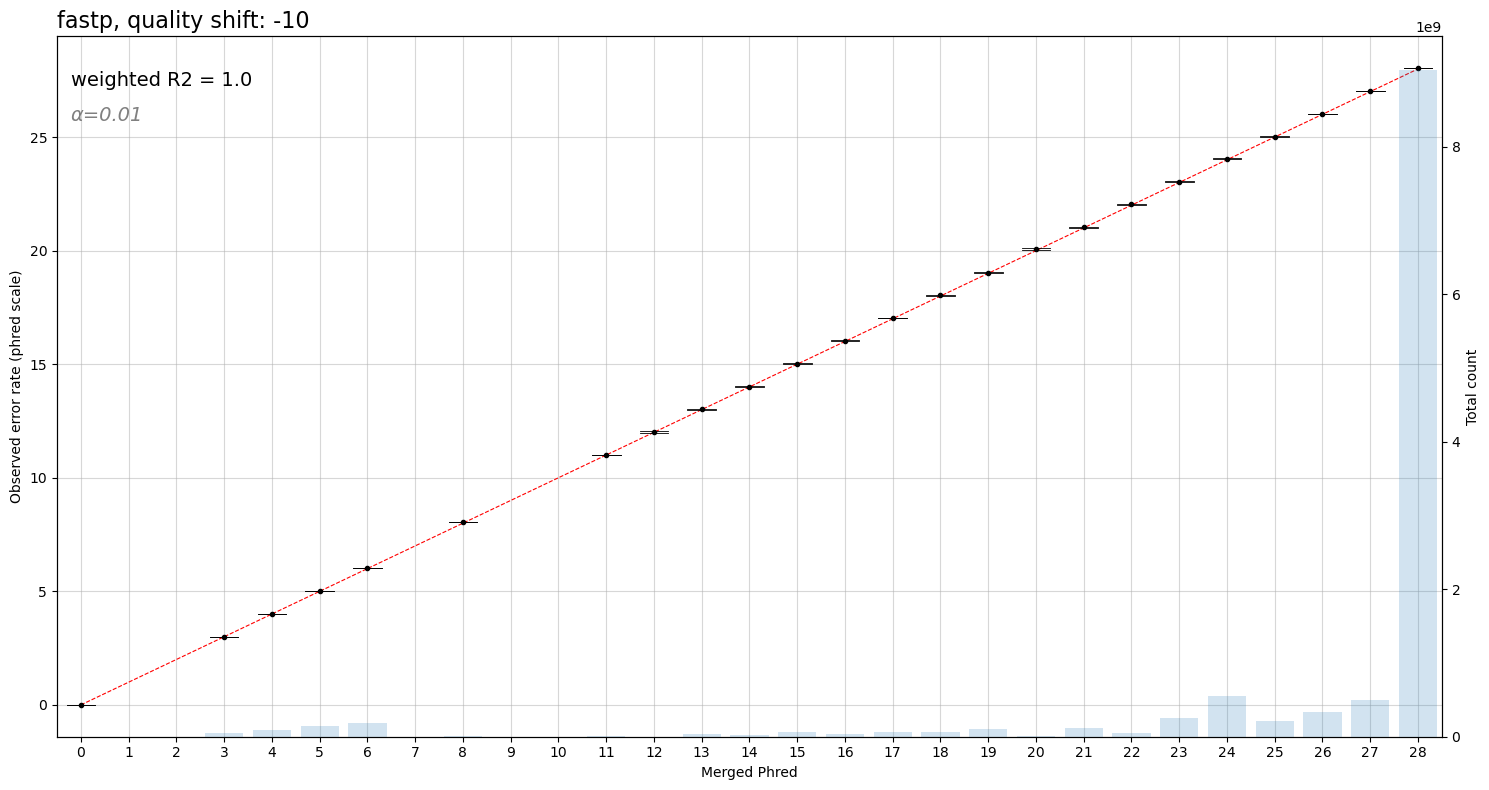

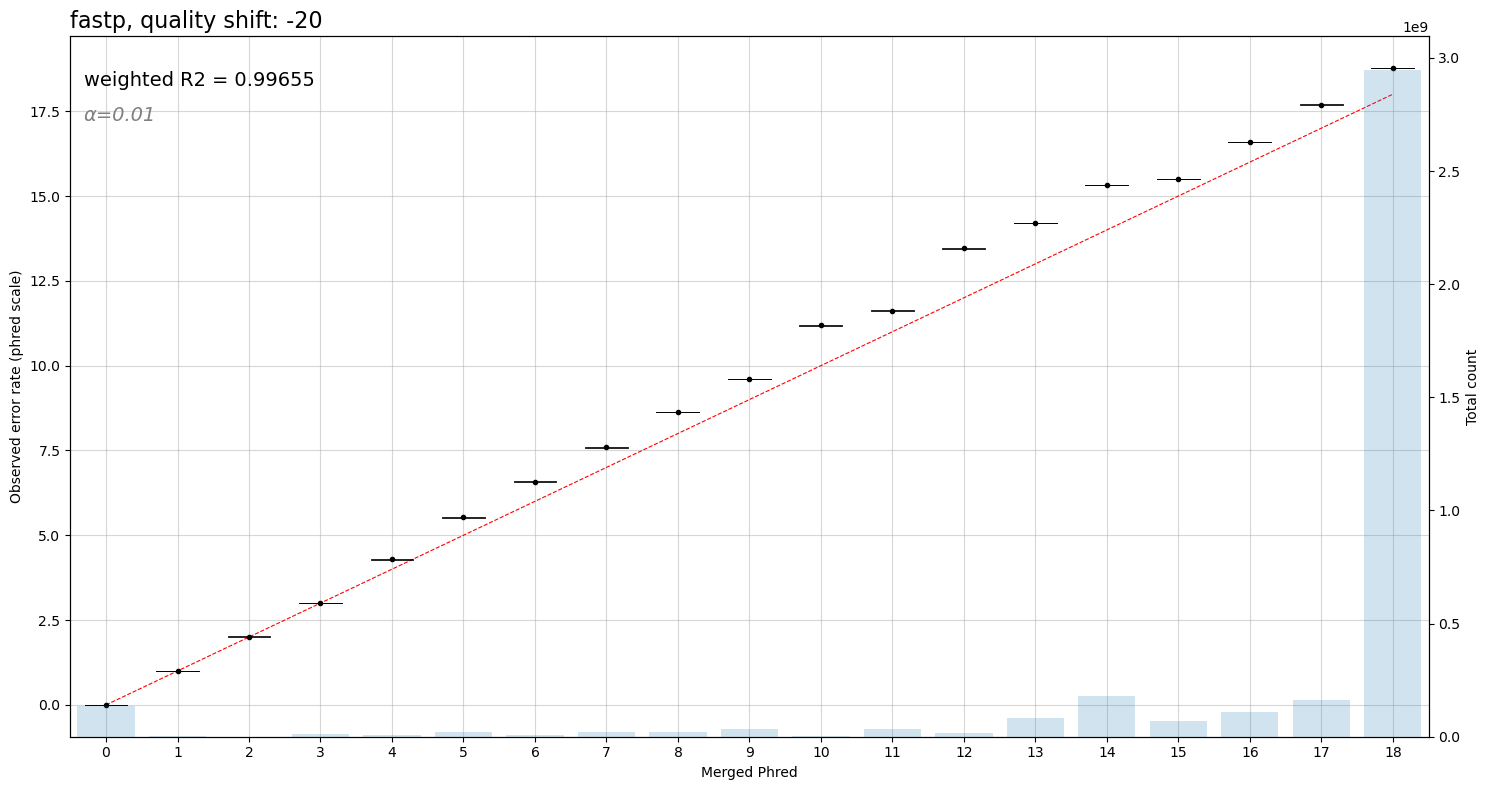

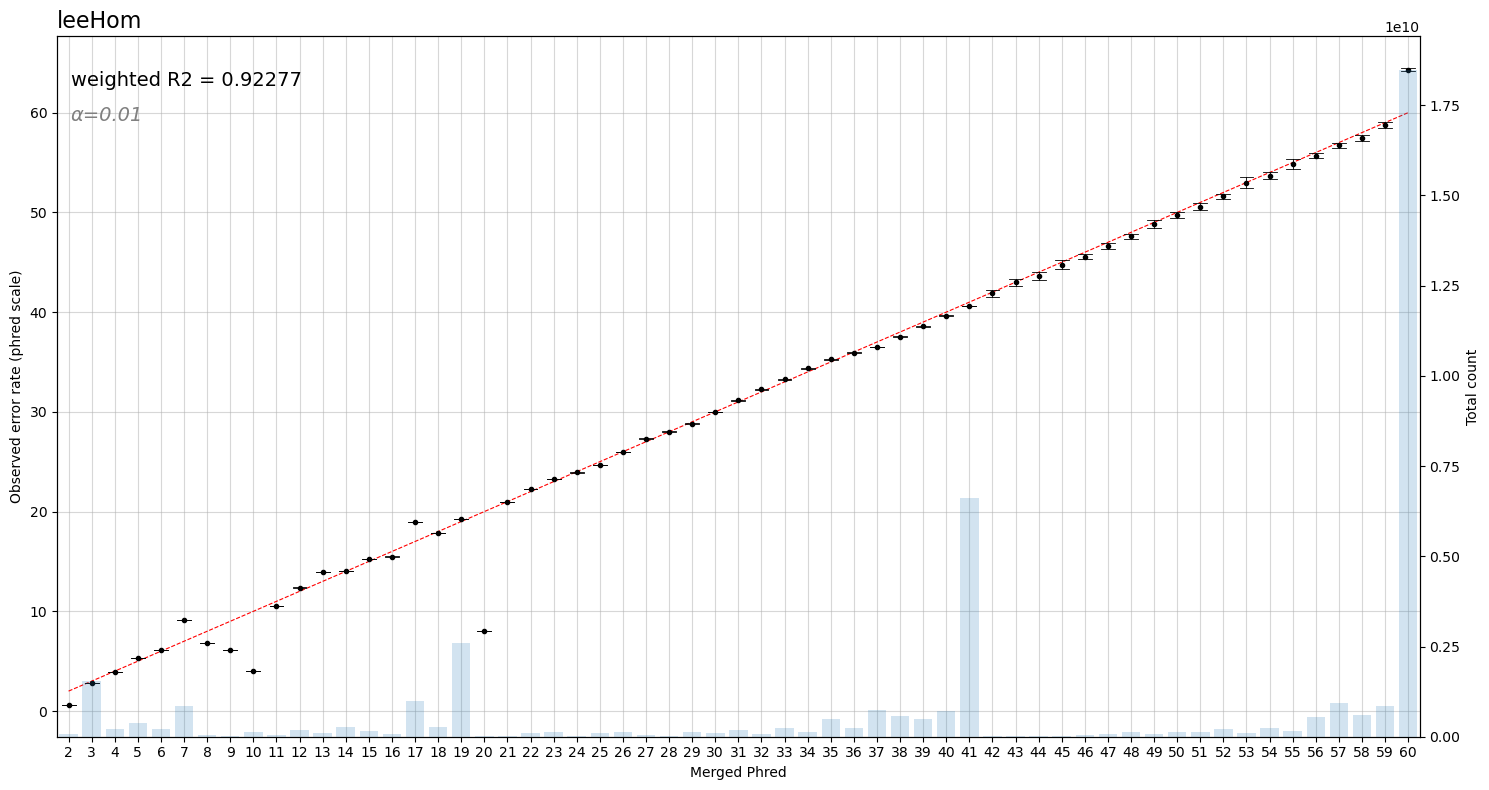

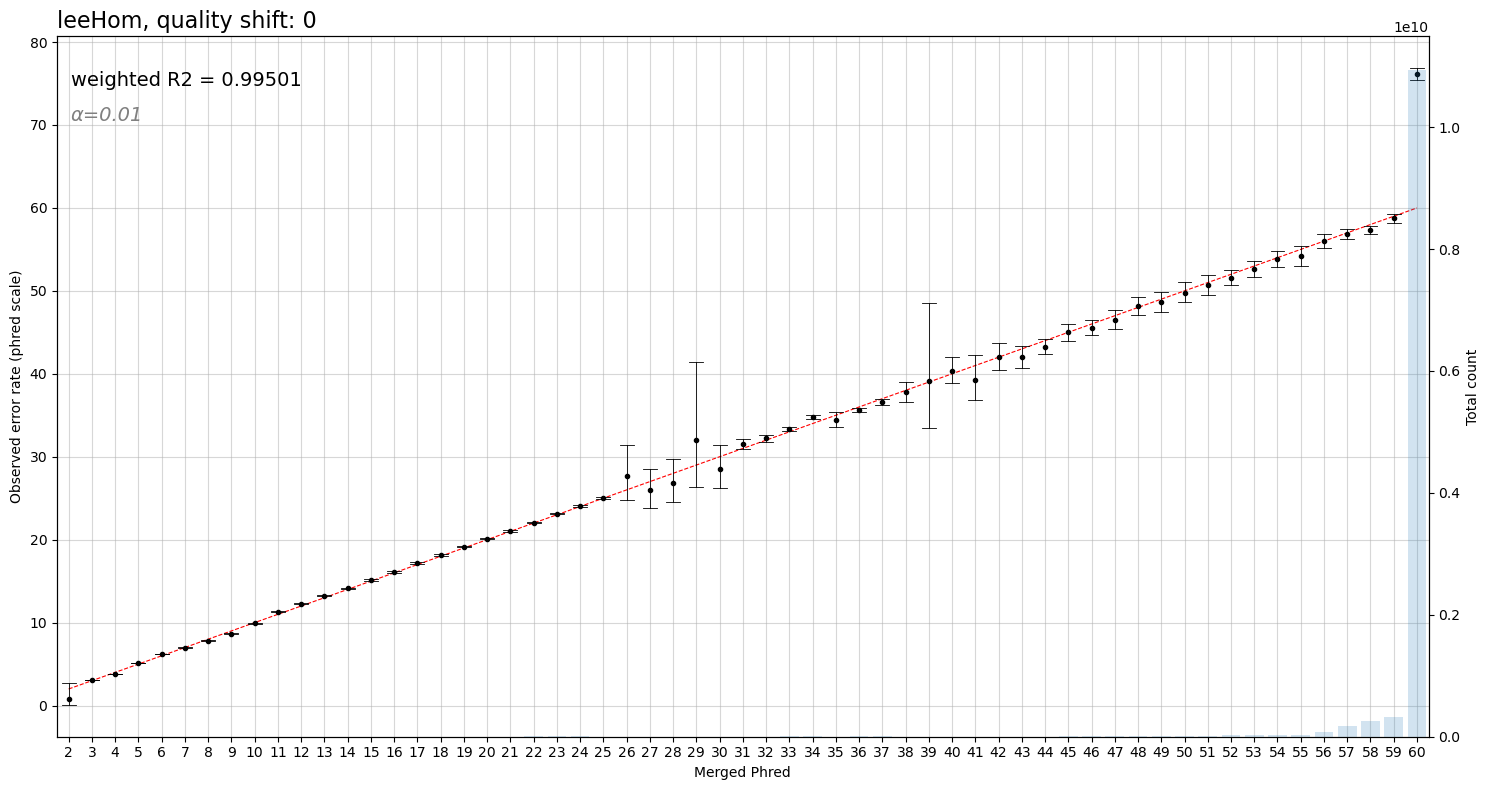

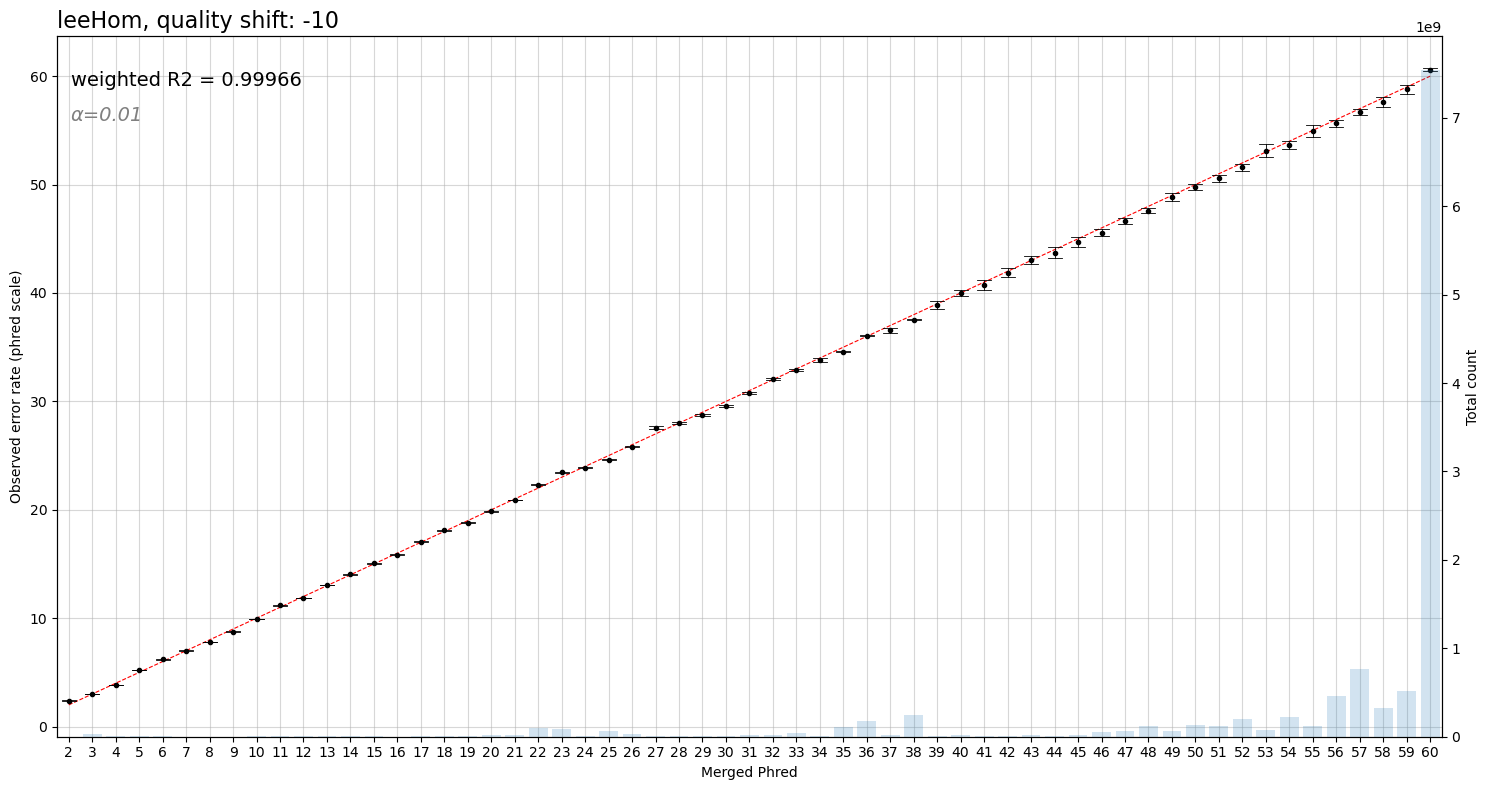

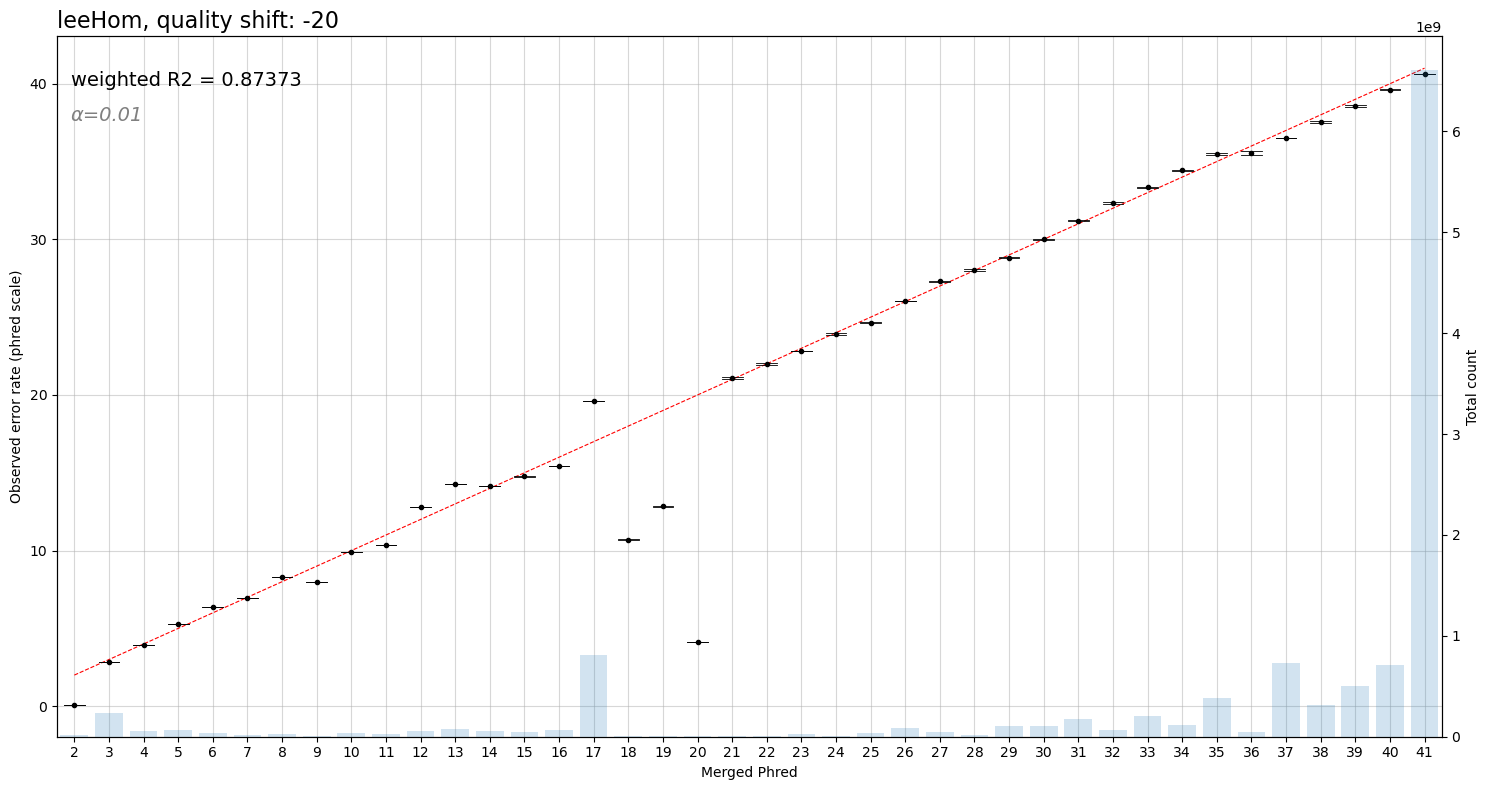

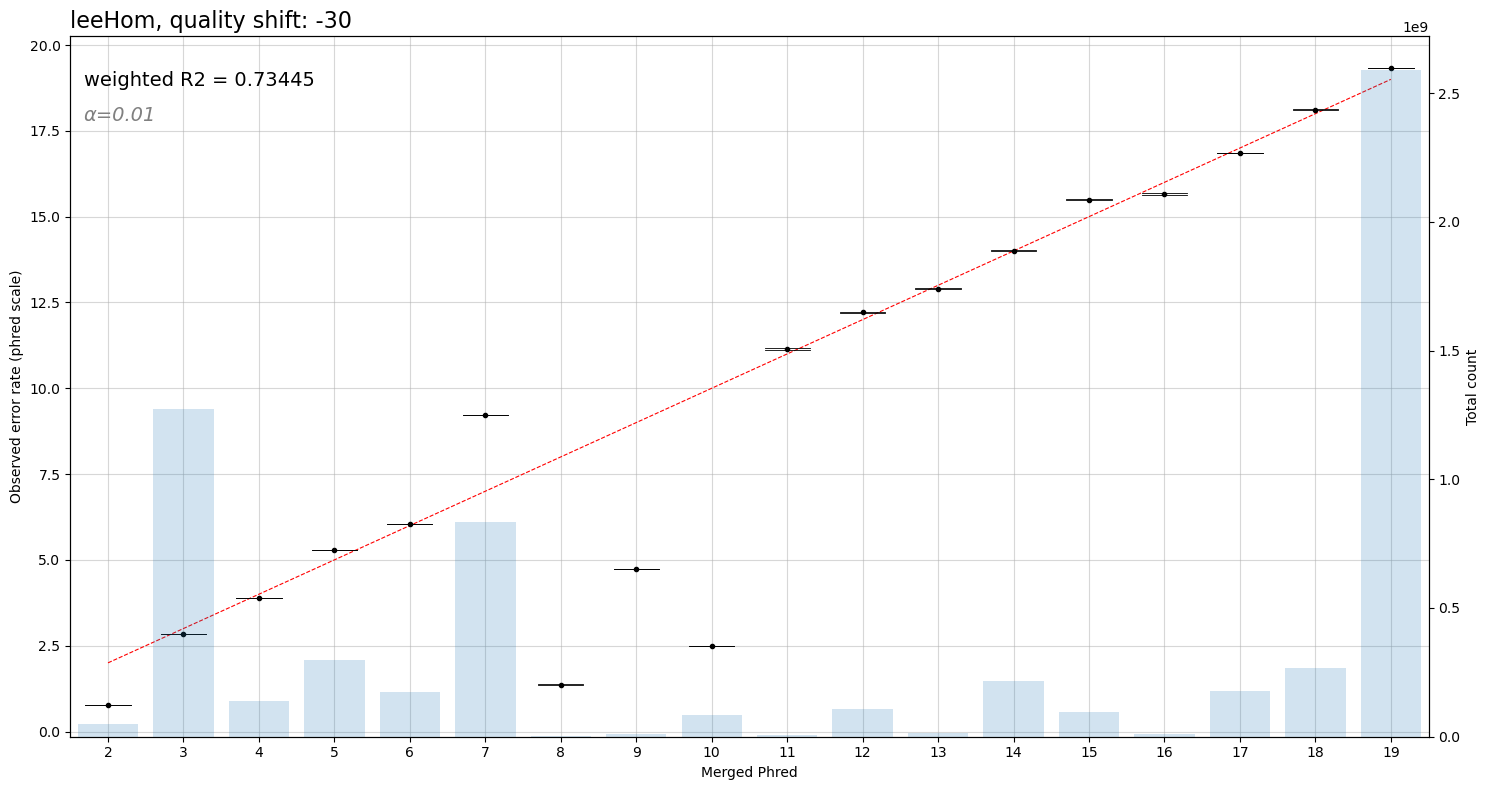

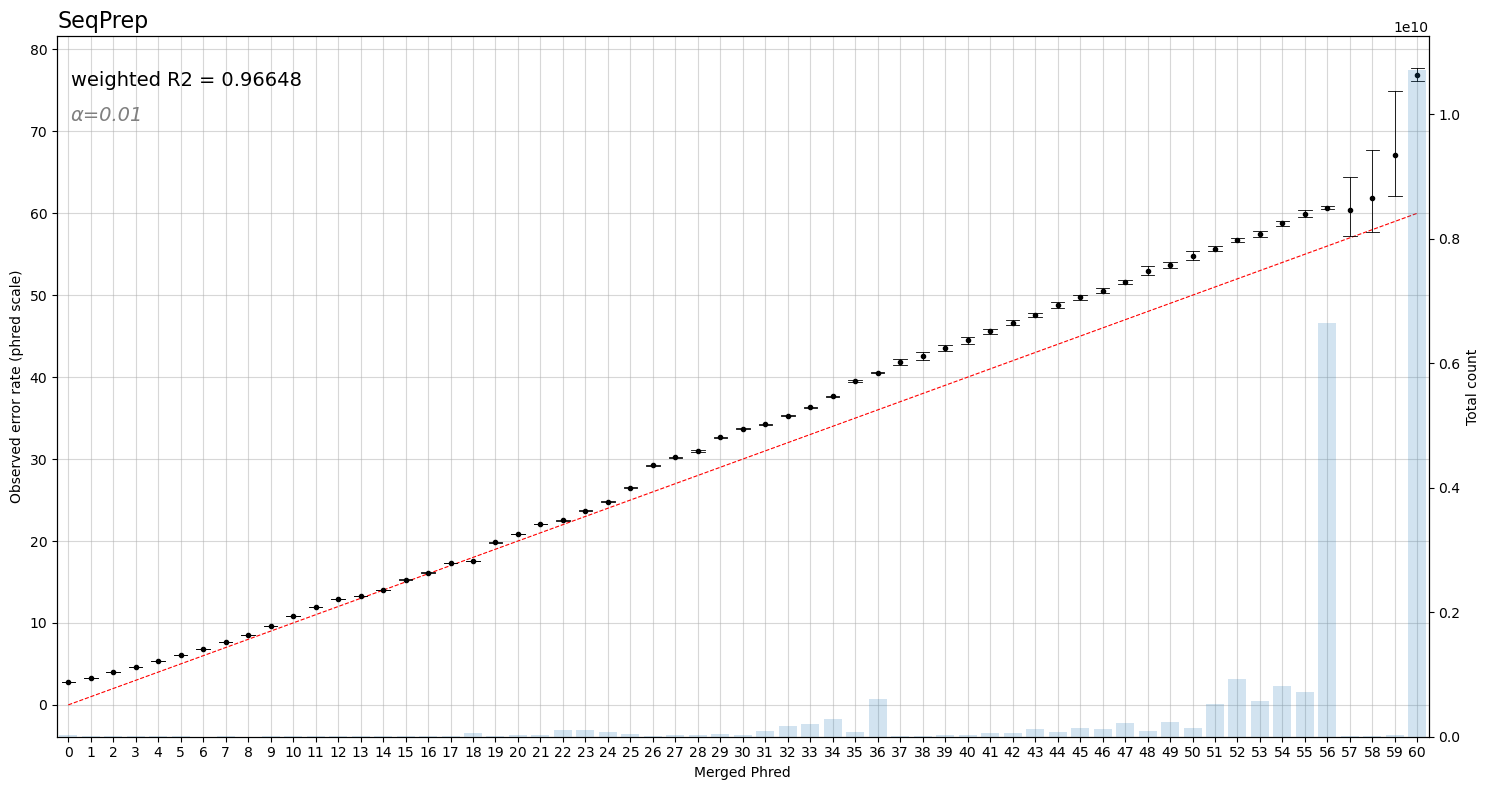

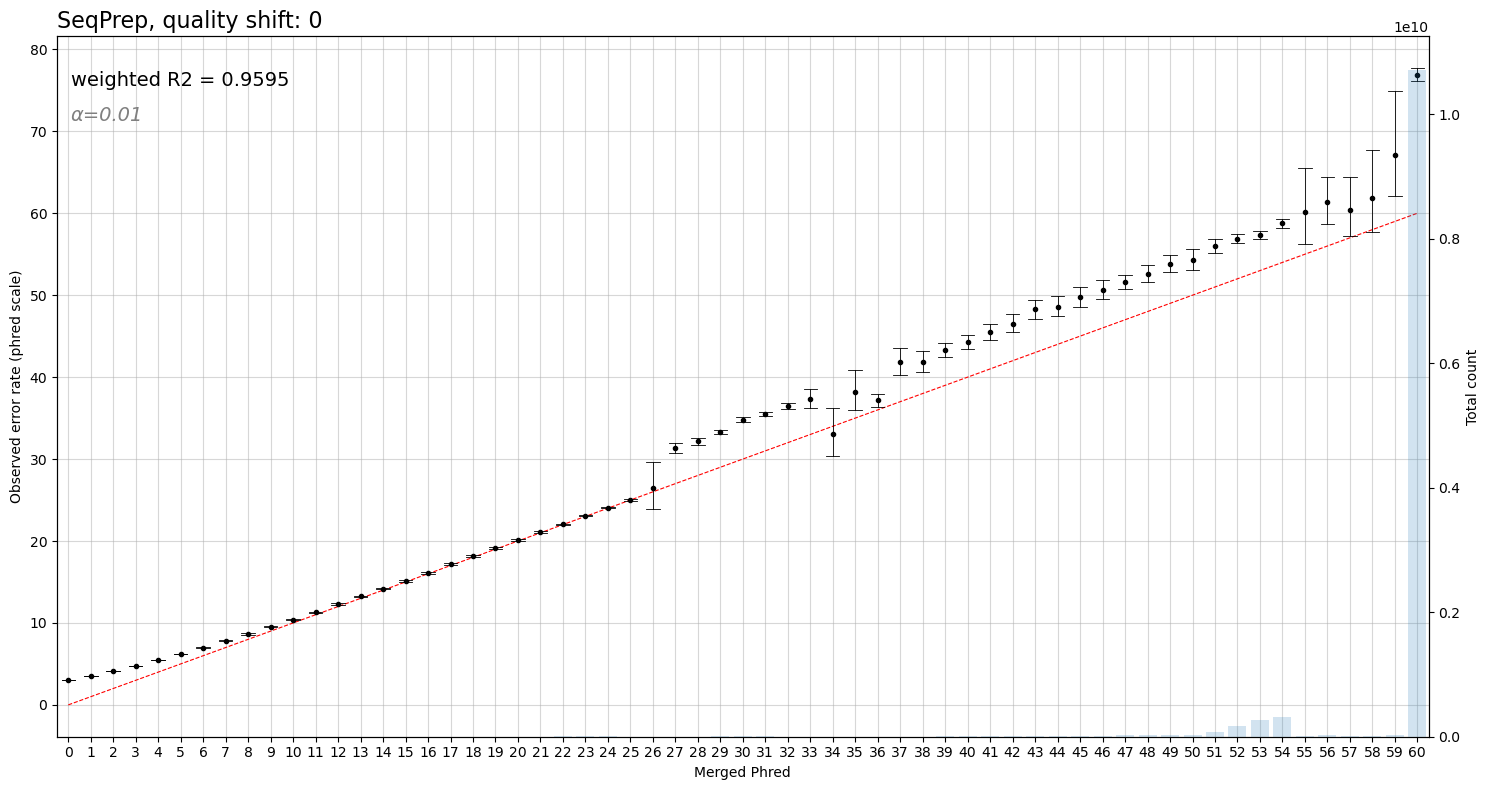

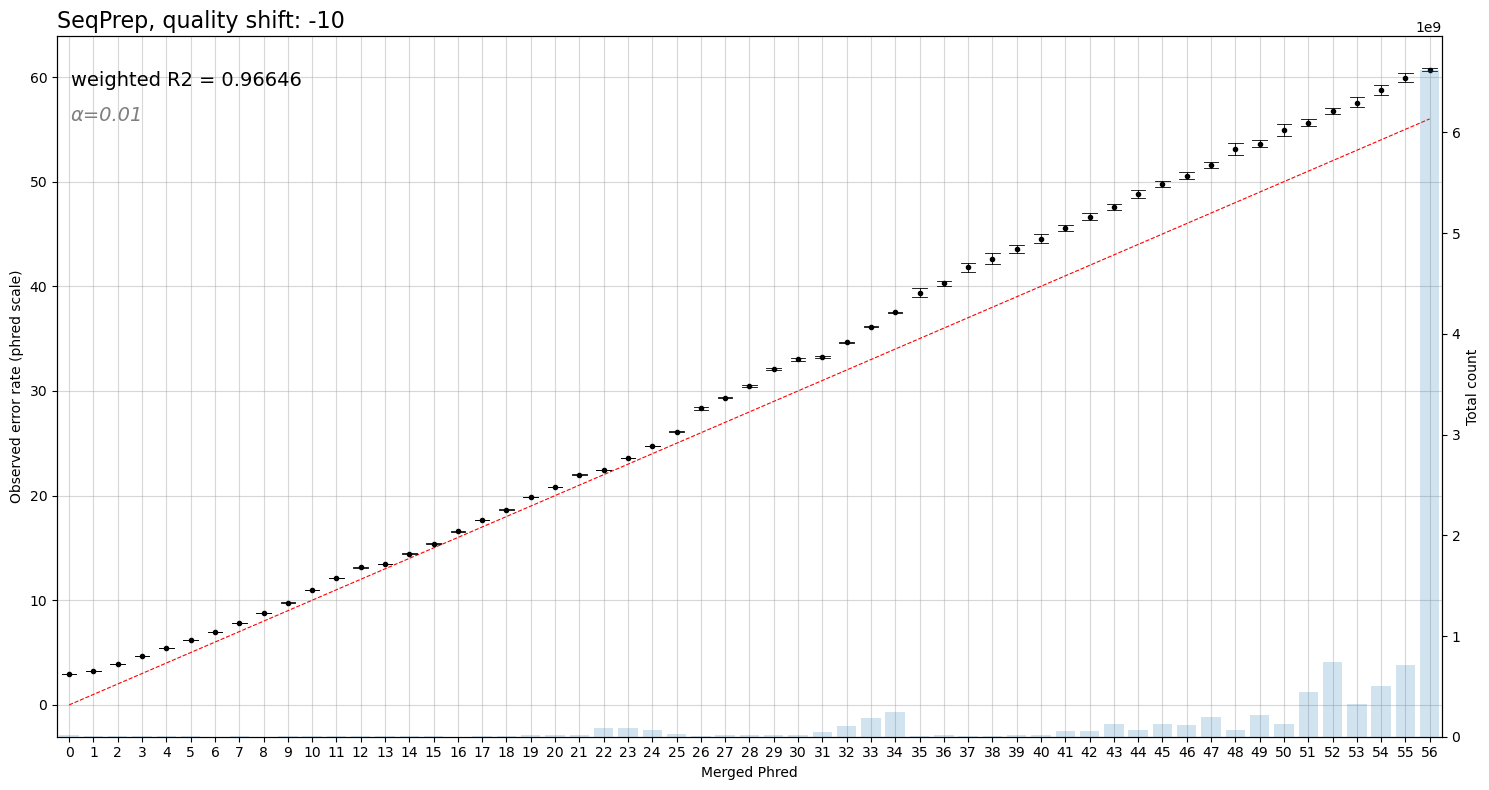

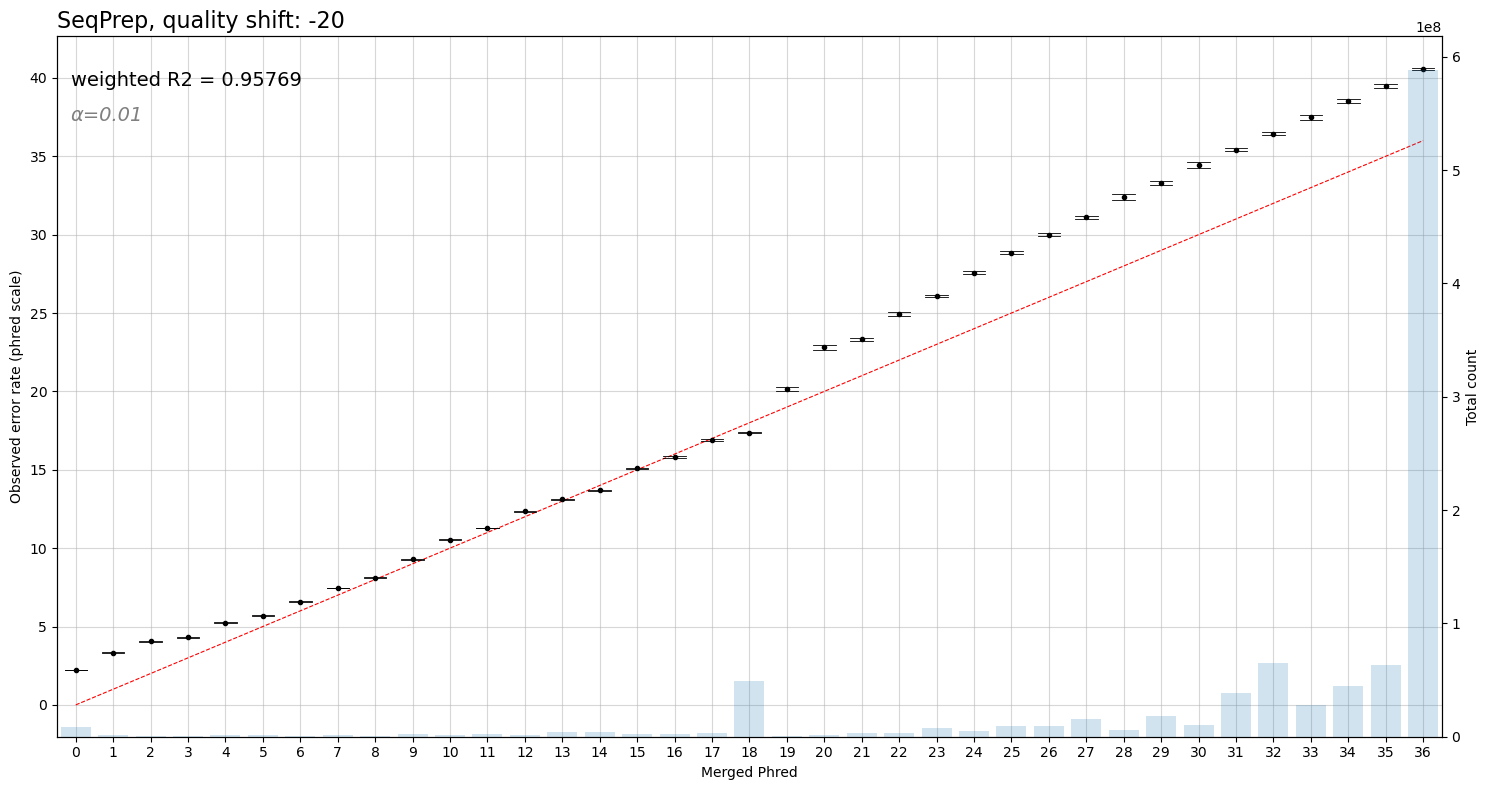

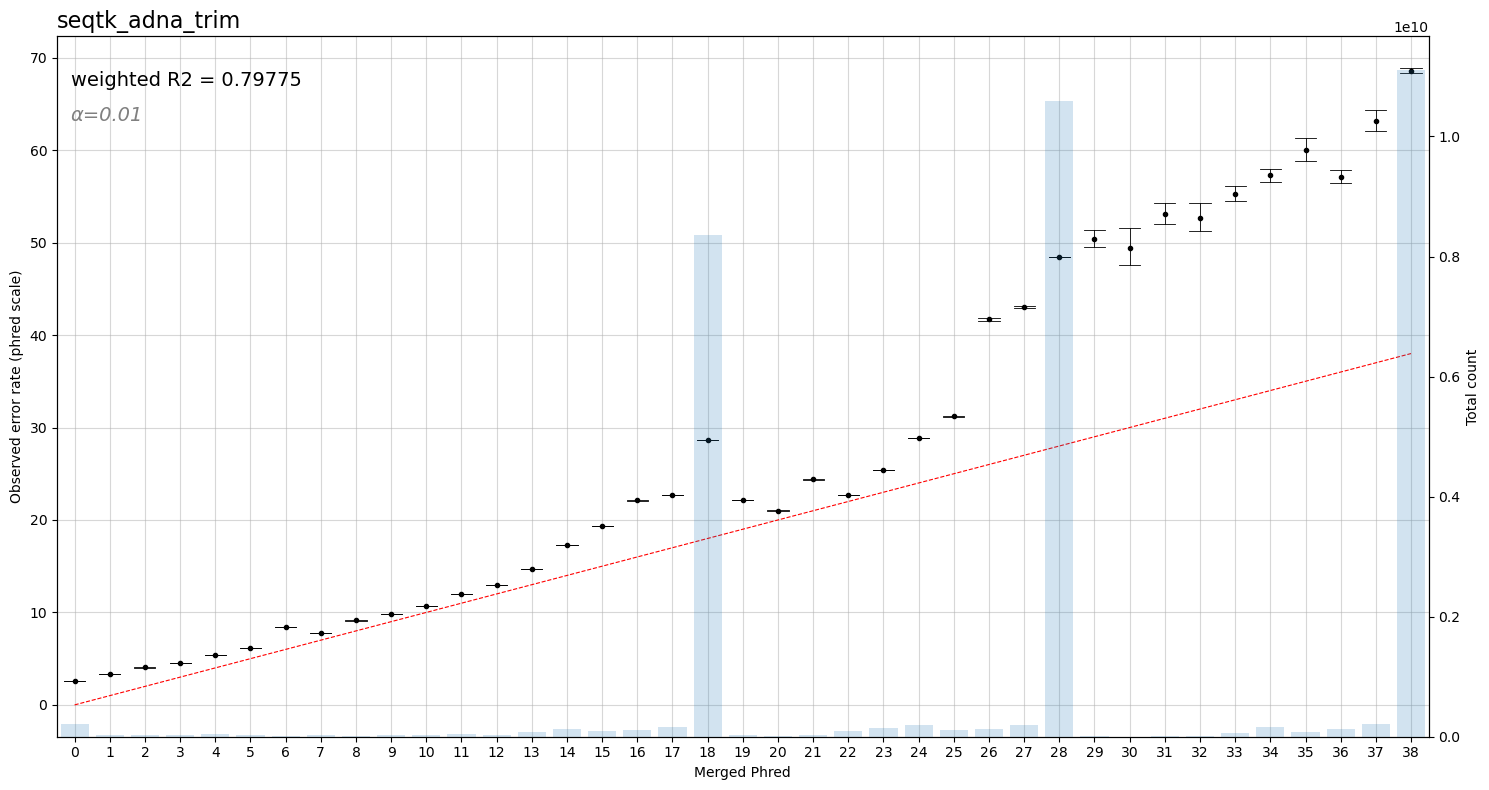

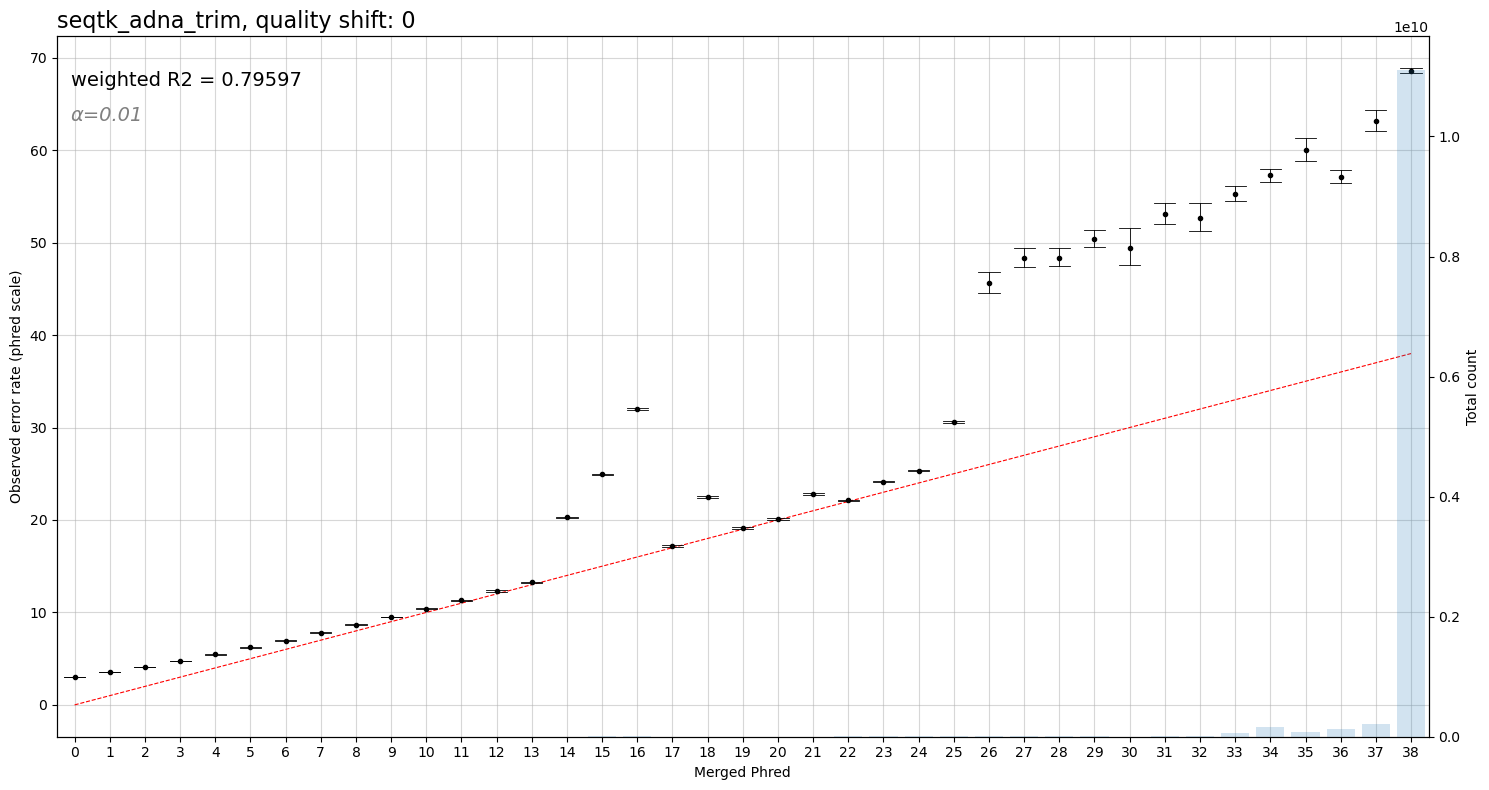

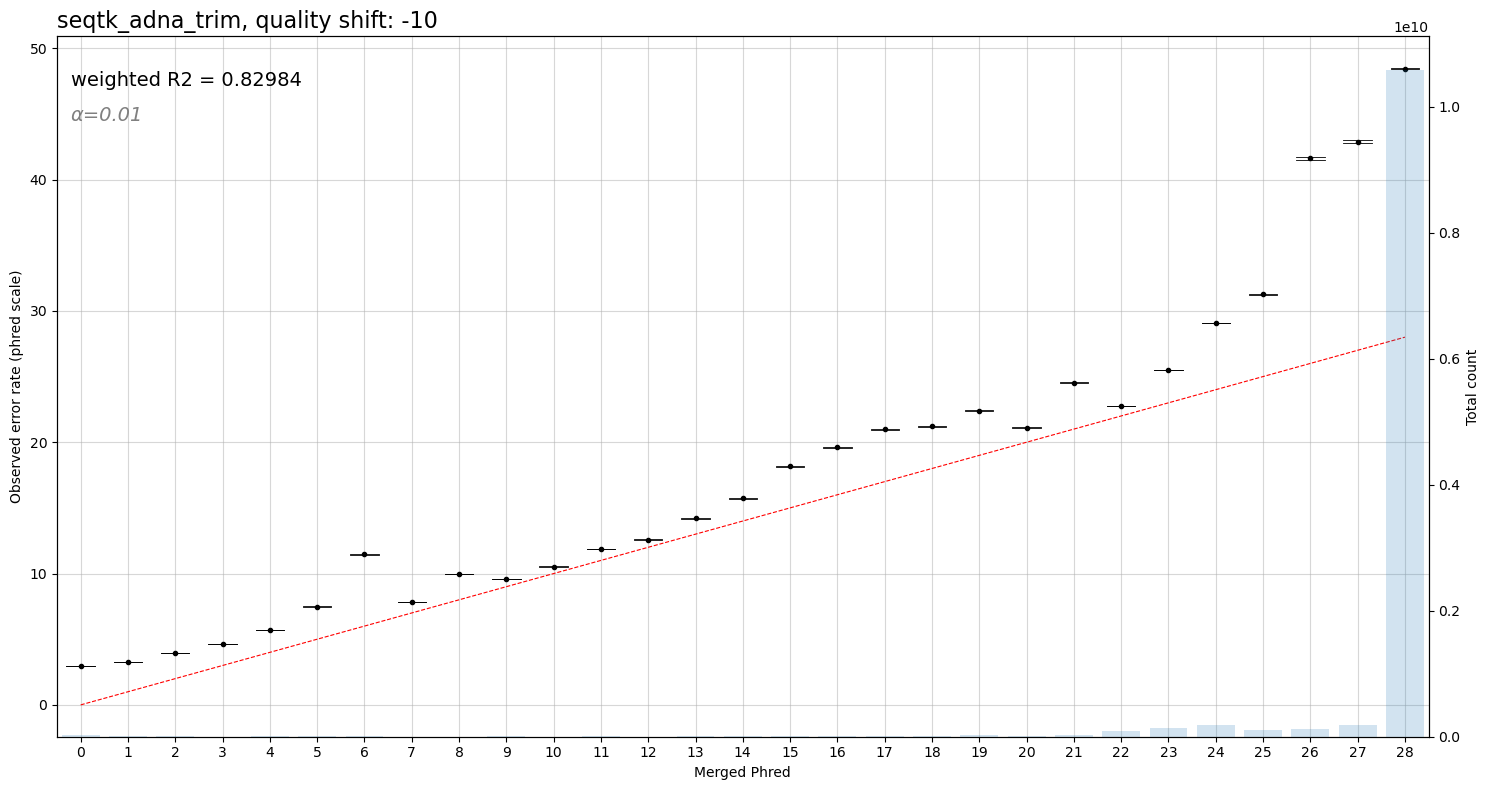

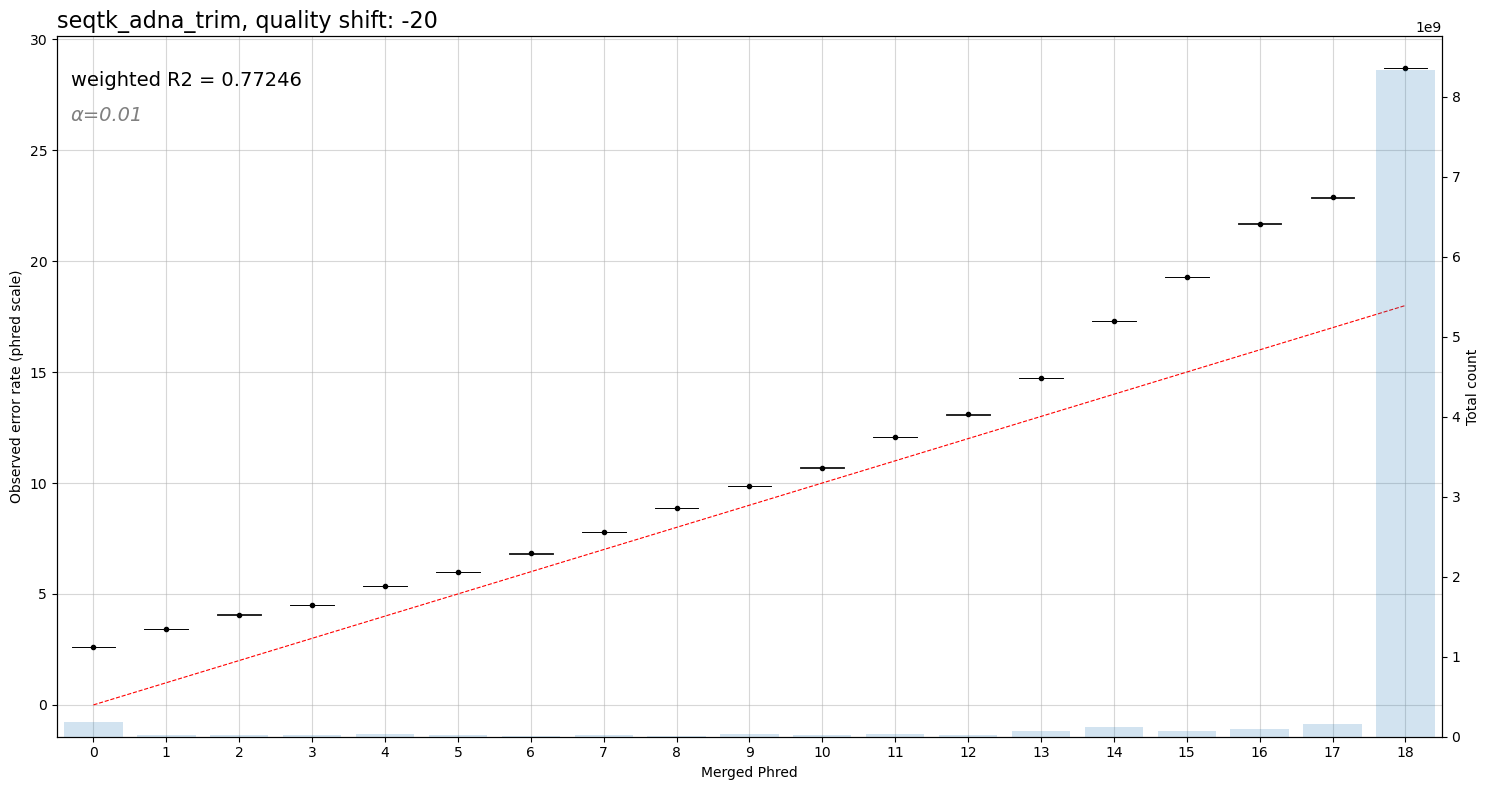

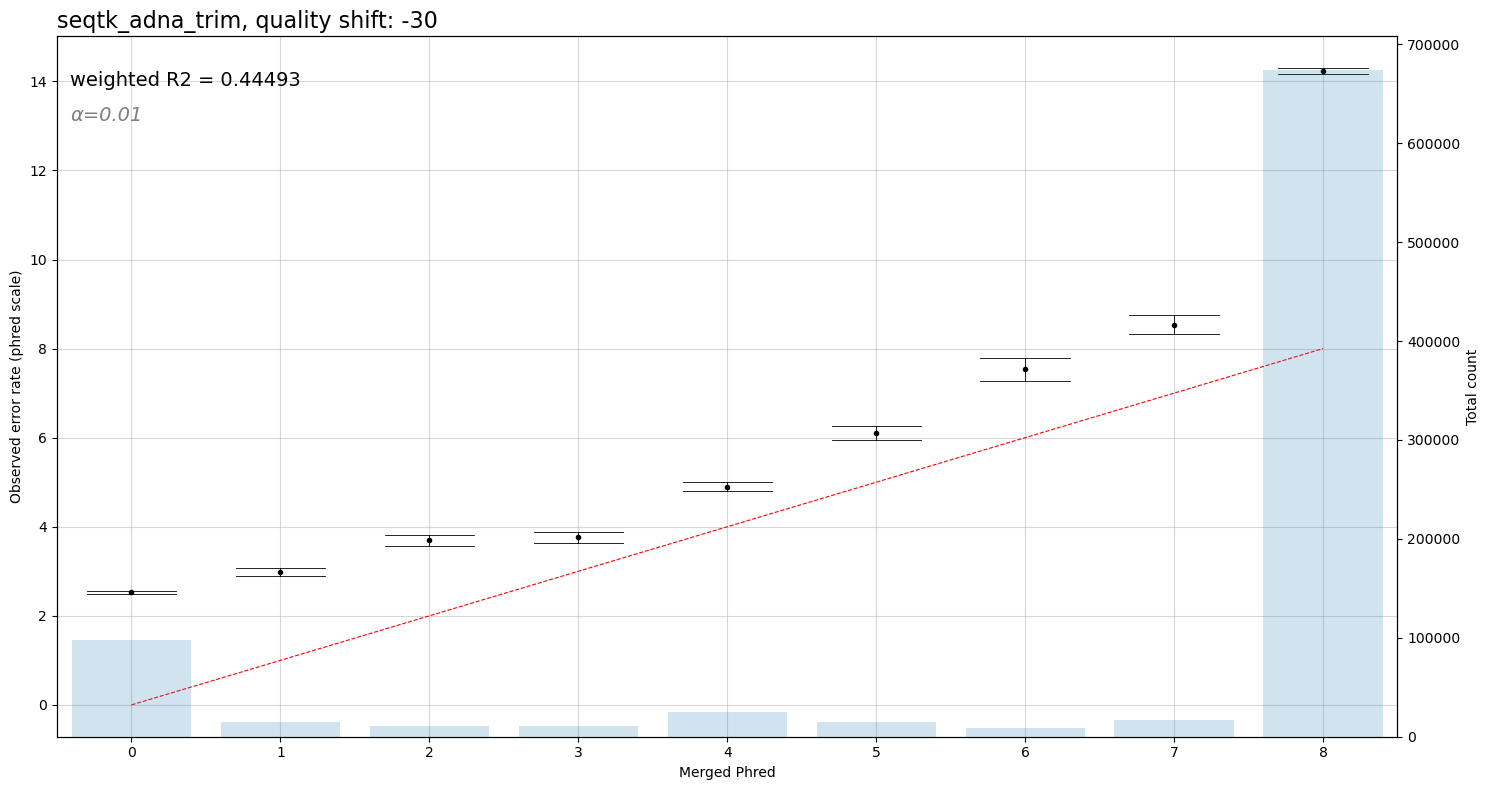

In [111]:
infile = "/mnt/c/Users/s202633/Documents/Master thesis/DNA_reconstruct/observed_merge_phred/output/evaluation/all_merged.csv"
outdir = None
# outdir = "/mnt/c/Users/s202633/Documents/Master thesis/DNA_reconstruct/observed_merge_phred/output/plots"
main(infile, outdir)

In [23]:
df_program.sort_values("predicted_phred").head()

,Unnamed: 0,program,nfrags,fraglen,qual_shift,alpha,predicted_phred,predicted_error,n_matches,n_mismatches,n_total,p_mismatch,p_mismatch_lower,p_mismatch_upper,observed_phred,observed_phred_lower,observed_phred_upper
414,0,fastp,100000000,120,-20,0.01,0,1.000000,0,134118080,134118080,1.000000,1.000000,1.000000,0.000000,0.000000,1.715675e-07
390,0,fastp,100000000,120,-10,0.01,0,1.000000,0,518348,518348,1.000000,0.999990,1.000000,0.000000,0.000000,4.439161e-05
415,1,fastp,100000000,120,-20,0.01,1,0.794328,717373,2764727,3482100,0.793983,0.793424,0.794541,1.001890,0.998839,1.004948e+00
366,0,fastp,100000000,120,0,0.01,2,0.630957,193081,29582,222663,0.132855,0.131008,0.134718,8.766205,8.705732,8.827012e+00
416,2,fastp,100000000,120,-20,0.01,2,0.630957,137289,234237,371526,0.630473,0.628430,0.632512,2.003337,1.989311,2.017431e+00


In [21]:
df_combined.head()

,n_matches,n_mismatches,n_total,predicted_phred,predicted_p_mismatch,p_mismatch,p_mismatch_lower,p_mismatch_upper,observed_phred,observed_phred_lower,observed_phred_upper
predicted_phred,,,,,,,,,,,
1,232097,26202313,26434410,1,0.794328,0.991220,0.991173,0.991267,0.038300,0.038095,0.038505
2,127704409,131467089,259171498,2,0.630957,0.507259,0.507179,0.507339,2.947702,2.947017,2.948387
3,42718202,37227901,79946103,3,0.501187,0.465662,0.465519,0.465806,3.319287,3.317947,3.320628
4,38571529,22478604,61050133,4,0.398107,0.368199,0.368040,0.368358,4.339173,4.337298,4.341049
5,45870242,18723383,64593625,5,0.316228,0.289864,0.289719,0.290010,5.378053,5.375875,5.380232


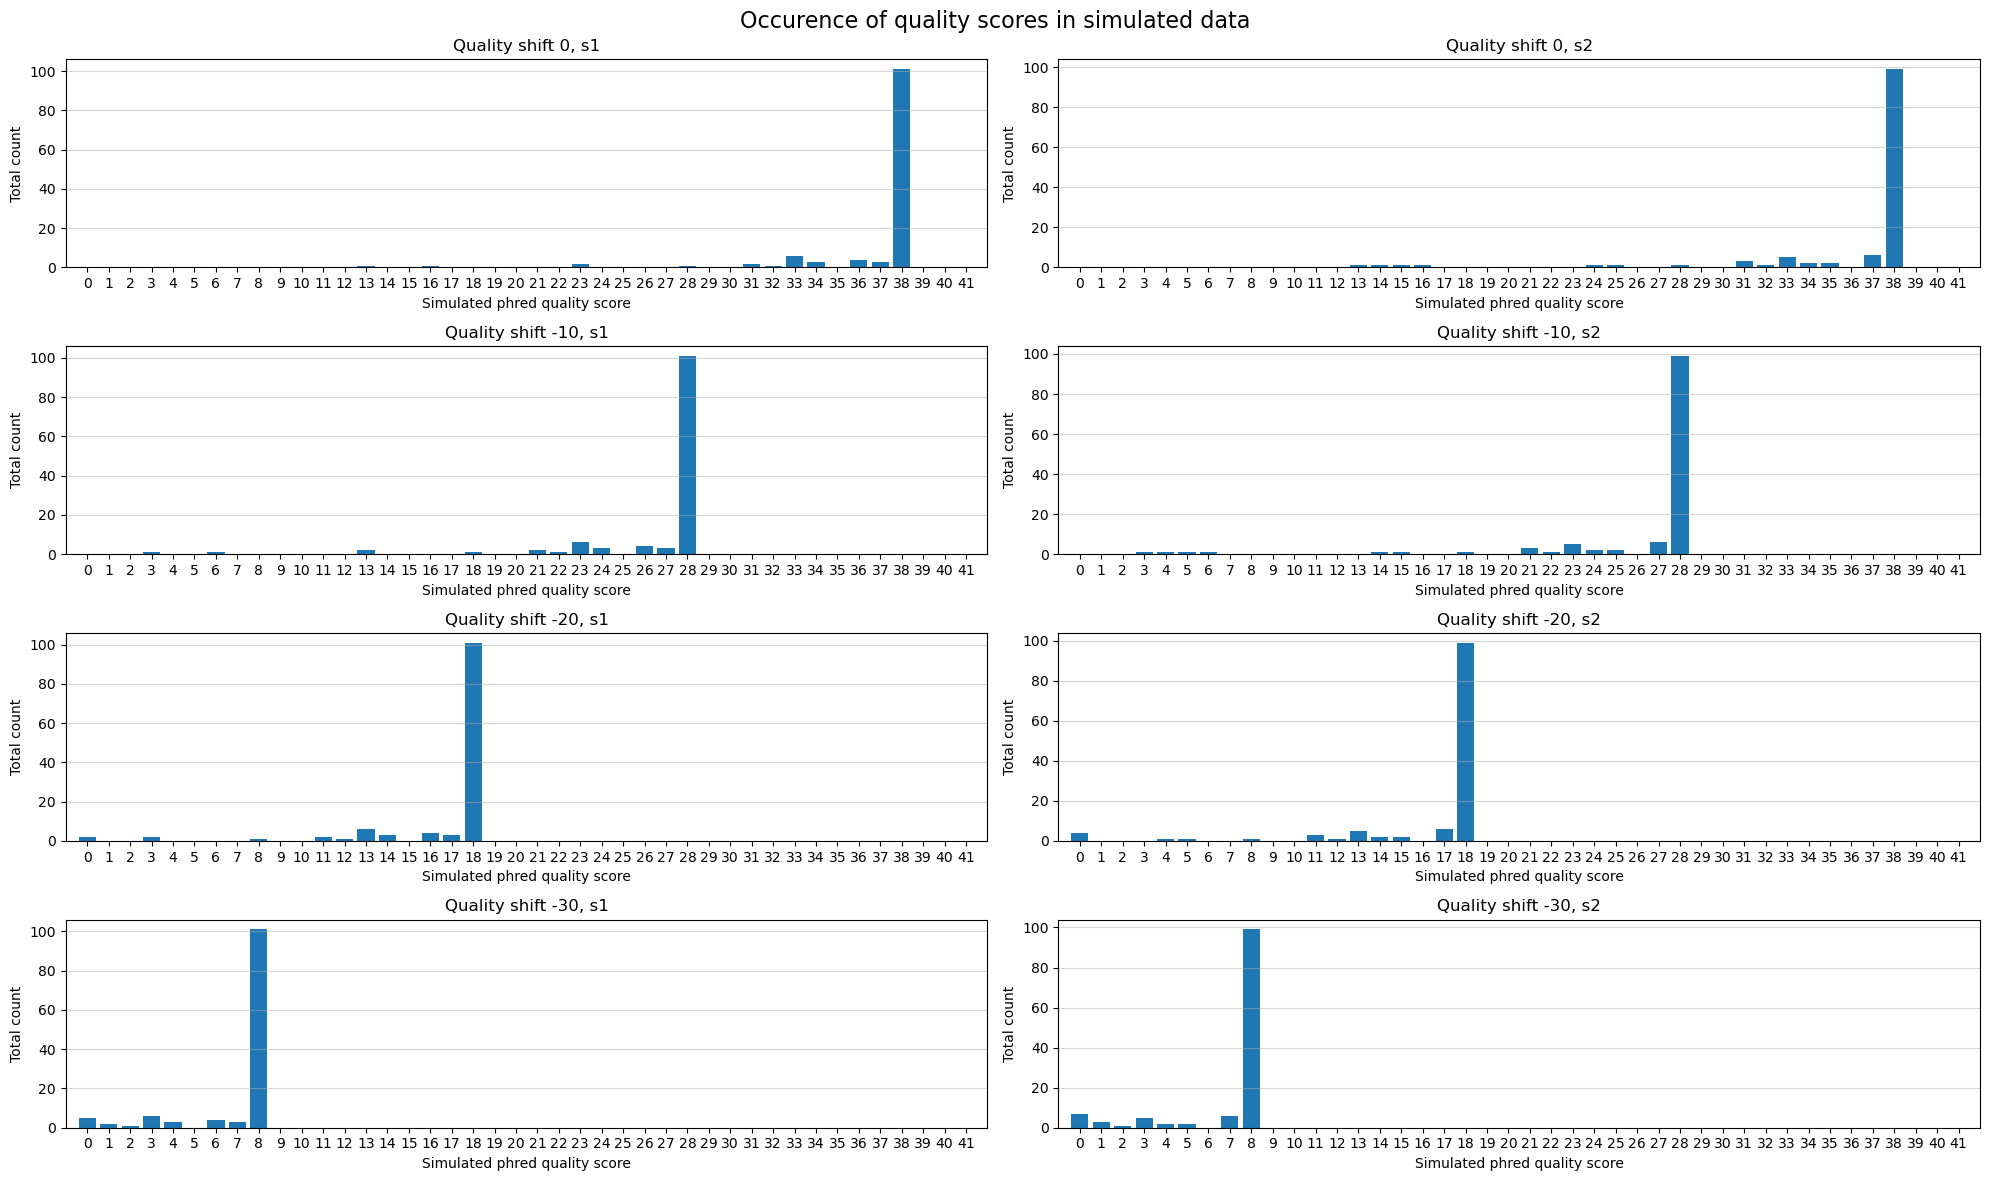

In [110]:
def plot_simulated_phred_occurence(df, outdir):
    
    
    fig, axes = plt.subplots(4, 2, figsize=(20, 12))
    
    reads = sorted(df["read"].unique())
    quality_shifts = sorted(df["quality_shift"].unique(), reverse=True)
    
    
    for i in range(len(reads)):
        read = reads[i]
        df_read = df[df["read"] == read]
        for j in range(len(quality_shifts)):
            q_shift = quality_shifts[j]
            df_qs = df_read[df_read["quality_shift"] == q_shift]
            
            ax = axes[j][i]
            ax.bar(df_qs["quality_score"], df_qs["count"])
    
            ax.set_xlim(-1, 42)
            ax.set_xticks(range(0, 42))
            #ax.xaxis.set_tick_params(labelsize=5)
            ax.set_xlabel(f"Simulated phred quality score")
            ax.set_ylabel(f"Total count")
            ax.set_title(f"Quality shift {q_shift}, {read}")
            ax.grid(axis="y", alpha=0.5)
            
    fig.suptitle("Occurence of quality scores in simulated data", 
                 fontsize=16)
    
    # Save plot
    fig.tight_layout()
    if outdir is not None:
        plt.savefig(f"{outdir}/simulated_phred_occurence.png", 
                    dpi='figure', 
                    format="png")
    else:
        plt.show()
    plt.close(fig)
    
    
infile = "/mnt/c/Users/s202633/Documents/Master thesis/DNA_reconstruct/observed_merge_phred/output/evaluation/simulated_reads.csv"
outdir = None
df = pd.read_csv(infile)
plot_simulated_phred_occurence(df, outdir)